In [2380]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
import re
from scipy import stats

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.decomposition import PCA

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [2129]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
cp = pd.read_csv('client_profile.csv')
payments = pd.read_csv('payments.csv')
history = pd.read_csv('applications_history.csv')
bki = pd.read_csv('bki.csv')

In [38]:
bki.duplicated().sum()

0

In [40]:
for column in bki.columns:
    if bki[column].nunique() < 2:
        print(column)

In [24]:
train[TARGET].value_counts(normalize=True)

0   0.9192
1   0.0808
Name: TARGET, dtype: float64

In [1518]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:    
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

def calculate_feature_separating_ability(
    features: pd.DataFrame, target: pd.Series, fill_value: float = -9999) -> pd.DataFrame:

    scores = {}
    for feature in features:
        score = roc_auc_score(
            target, features[feature].fillna(fill_value)
        )
        scores[feature] = 2*score - 1

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

def _predict(estimator, x_valid, probas=True):
    if hasattr(estimator, "predict_proba") and probas:
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True,
                                     probas: bool = False
                                     ) -> pd.Series:
    y_pred = _predict(estimator, x_valid, probas)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_, probas)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

def make_modify_cross_validation(X: pd.DataFrame,
                                 y: pd.Series,
                                 estimator: object,
                                 metric: callable,
                                 cv_strategy,
                                 error_to_be_outlier: None,
                                 verbose: bool = True,
                                 proba: bool = True,
                                 early: bool = False):

    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        if early:
            estimator.fit(x_train, y_train, 
                          eval_set=[(x_train, y_train), (x_valid, y_valid)], 
                          early_stopping_rounds=early,
                          verbose=-1)
        else:
            estimator.fit(x_train, y_train)
        if proba:
            y_train_pred = estimator.predict_proba(x_train)[:,1]
            y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        else:
            y_train_pred = estimator.predict(x_train)
            y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        if not error_to_be_outlier:
            fold_valid_scores.append(metric(y_valid, y_valid_pred))
        else:
            # mask = ((y_valid - y_valid_pred) / y_valid) < error_to_be_outlier  # for regression task: 0.05
            y_valid_pred = pd.Series(data=y_valid_pred, index=y_valid.index, name='predictions')
            outliers = iso.predict(x_valid.select_dtypes(include="number"))
            mask = y_valid[outliers == 1].index
            fold_valid_scores.append(metric(y_valid.loc[mask], y_valid_pred.loc[mask]))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if verbose:
            print(msg)
            print("="*69)
        if hasattr(estimator, "copy"):
            est = estimator.copy()
            estimators.append(est)
        else:
            est = clone(estimator)
            if early:
                estimators.append(est.fit(x_train, y_train, 
                                          eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                          early_stopping_rounds=early,
                                          verbose=-1))
            else:
                estimators.append(est.fit(x_train, y_train))

    if not error_to_be_outlier:
        oof_score = metric(y, oof_predictions)
    else:
        # mask = ((y - oof_predictions) / y) < error_to_be_outlier  # for regression task
        oof_predictions = pd.Series(data=oof_predictions, index=y.index, name="oof_predictions")
        outliers = iso.predict(X.select_dtypes(include="number"))
        mask = y[outliers == 1].index
        oof_score = metric(y.loc[mask], oof_predictions.loc[mask])

    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

def reduce_memory_df(df):
    """Reduce memory usage by converting data to more appropriate dtypes"""
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

def mean_scores(scores, target):
    scores_list = [
        (scores.mean(axis=1), 'AMean score: '),
        (stats.gmean(scores, axis=1), 'GMean score: '),
        (scores.rank().mean(axis=1), 'Rank  score: '),
        (stats.gmean(scores.rank(), axis=1), 'GMean  rank: ')
    ]

    for scores_mean in scores_list:
        score = roc_auc_score(target, scores_mean[0])
        print(f"{scores_mean[1]}{score:.5f}")

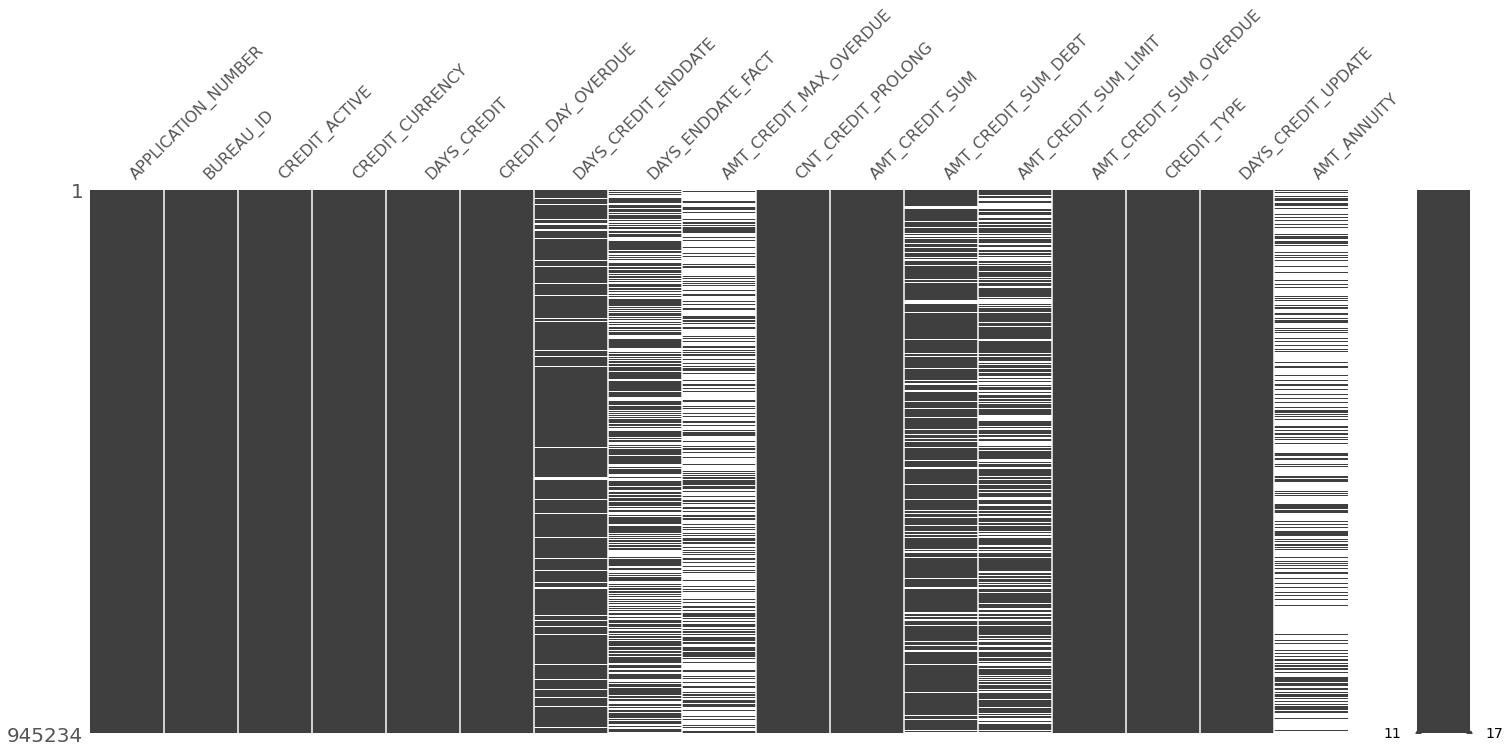

In [22]:
msno.matrix(bki)
plt.show()

<AxesSubplot:>

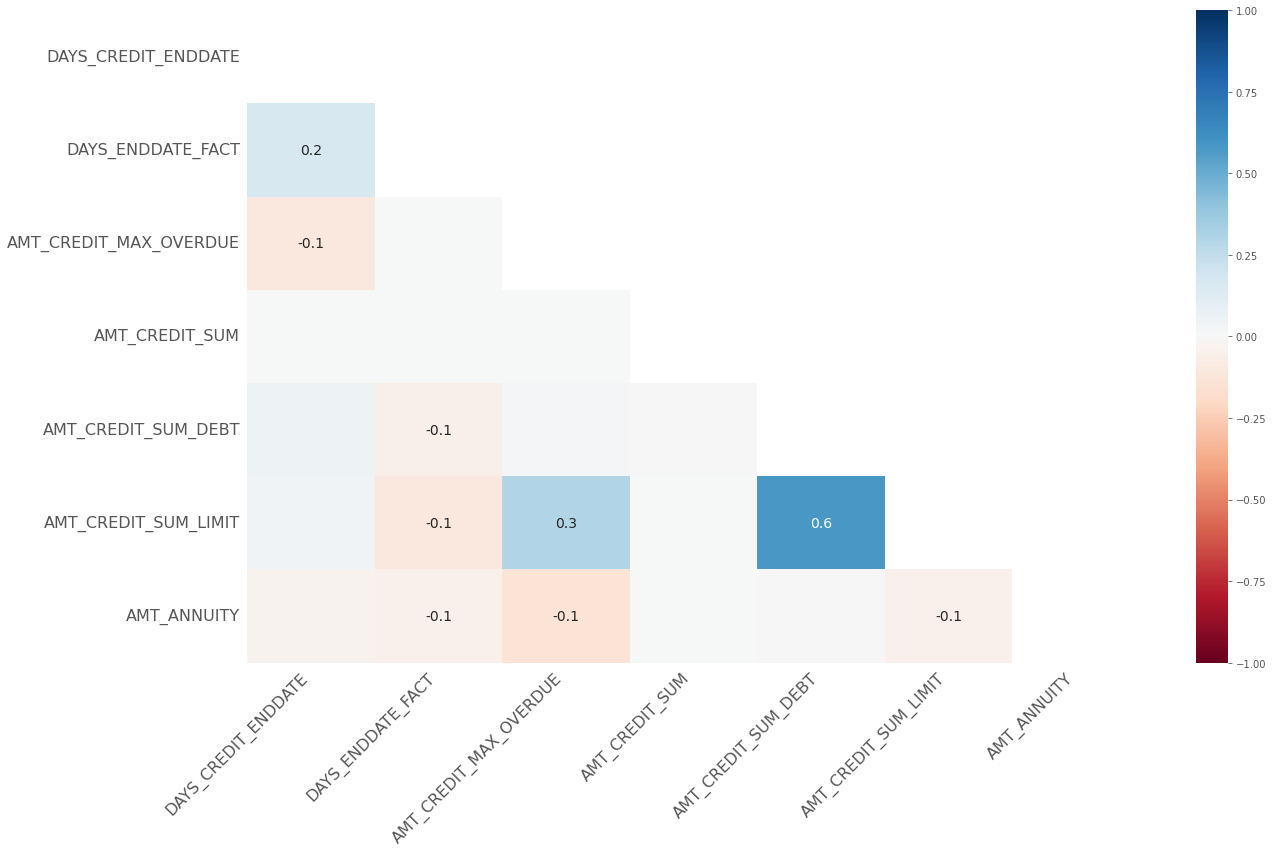

In [23]:
msno.heatmap(bki)

In [5]:
train_ids = set(train[ID_COL])
test_ids = set(test[ID_COL])

hist_ids = set(history[ID_COL])
bki_ids = set(bki[ID_COL])
pay_ids = set(payments[ID_COL])
cp_ids = set(cp[ID_COL])

In [42]:
bki.describe()

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,945234.0000,945234.0000,945234.0000,945234.0000,886797.0000,596274.0000,326557.0000,945234.0000,945229.0000,803483.0000,619267.0000,945234.0000,945234.0000,269330.0000
mean,123601560.6483,5974376.8836,1142.2182,0.7698,1819.6072,1018.0012,3784.2193,0.0063,354773.8094,136174.6950,6267.7180,38.2613,594.0563,16466.7875
std,102904.1170,533043.0812,795.0473,35.1736,4684.4478,715.0136,213382.2852,0.0949,1078780.9874,637028.1684,45280.2715,5156.0318,721.5056,393765.6555
min,123423340.0000,5001084.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-4705600.3200,-586406.1150,0.0000,0.0000,0.0000
25%,123512214.0000,5513773.0000,474.0000,0.0000,383.0000,426.0000,0.0000,0.0000,51210.0000,0.0000,0.0000,0.0000,33.0000,0.0000
50%,123601386.0000,5976502.5000,987.0000,0.0000,863.0000,897.0000,0.0000,0.0000,125470.8000,0.0000,0.0000,0.0000,396.0000,0.0000
75%,123690756.0000,6435551.0000,1666.0000,0.0000,1504.0000,1489.0000,0.0000,0.0000,315000.0000,39732.7500,0.0000,0.0000,908.0000,13500.0000
max,123779594.0000,6942186.0000,2922.0000,2792.0000,42060.0000,42023.0000,115987185.0000,7.0000,396000000.0000,65441403.0000,4705600.3200,2387232.0000,41943.0000,118453423.5000


In [63]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [43]:
bki.fillna(0).skew()

APPLICATION_NUMBER         0.0009
BUREAU_ID                 -0.0078
DAYS_CREDIT                0.5820
CREDIT_DAY_OVERDUE        57.8462
DAYS_CREDIT_ENDDATE        5.7039
DAYS_ENDDATE_FACT          1.2044
AMT_CREDIT_MAX_OVERDUE   843.2748
CNT_CREDIT_PROLONG        19.5610
AMT_CREDIT_SUM            77.5113
AMT_CREDIT_SUM_DEBT       18.7082
AMT_CREDIT_SUM_LIMIT      22.6407
AMT_CREDIT_SUM_OVERDUE   269.0223
DAYS_CREDIT_UPDATE        11.4326
AMT_ANNUITY              364.2808
dtype: float64

In [46]:
bki.fillna(0).kurtosis()

APPLICATION_NUMBER           -1.2028
BUREAU_ID                    -1.1924
DAYS_CREDIT                  -0.7349
CREDIT_DAY_OVERDUE         3627.6347
DAYS_CREDIT_ENDDATE          32.7692
DAYS_ENDDATE_FACT             9.7196
AMT_CREDIT_MAX_OVERDUE   774071.7864
CNT_CREDIT_PROLONG          522.6822
AMT_CREDIT_SUM            21362.4941
AMT_CREDIT_SUM_DEBT         791.1073
AMT_CREDIT_SUM_LIMIT       1252.8622
AMT_CREDIT_SUM_OVERDUE    90120.6962
DAYS_CREDIT_UPDATE          601.4844
AMT_ANNUITY              164485.8474
dtype: float64

In [1277]:
def prepare_bki(df: pd.DataFrame, data_ids: list) -> pd.DataFrame:
    df = df.copy(deep=True)
    df.drop('BUREAU_ID', axis=1, inplace=True)
    # fill nans with zeros
    df.fillna(0, inplace=True)

    # clip large values 
    df['susp'] = 0
    
    sharp_columns = {column: df[column].kurtosis() for column in df.select_dtypes(include="number").columns}
    for column, value in sharp_columns.items():
        if np.abs(value) > 10:
            condition = ((df[column] < np.percentile(df[column], 1)) | (df[column] > np.percentile(df[column], 99)))
            df.loc[condition, 'susp'] = 1
            # p1 = np.percentile(df[column], 1)
            # p2 = np.percentile(df[column], 99)
            # df[column] = np.clip(df[column], p1, p2)
    
    # create new features: mean and sum of AMTs grouped by credit-type
    amount_cols = [col for col in df.columns if col.startswith('AMT')]
    for i, column in enumerate(amount_cols, 1):
        df[f"{column}_CREDIT_TYPE"] = df.groupby('CREDIT_TYPE')[column].transform("mean")

    # reduce dataset size
    df = df[df[ID_COL].isin(list(data_ids))]

    # mean and sum 
    agg_funcs = dict(zip(amount_cols, [["mean", "sum"]]*len(amount_cols)))
    mask = df['CREDIT_ACTIVE'] == 'Active'
    active_agg = create_numerical_aggs(data=df[mask], groupby_id=ID_COL, aggs=agg_funcs, suffix="_BY_CREDIT_ACTIVE").fillna(0)

    mask = df['CREDIT_ACTIVE'] == 'Closed'
    inactive_agg = create_numerical_aggs(data=df[mask], groupby_id=ID_COL, aggs=agg_funcs, suffix="_BY_CREDIT_INACTIVE").fillna(0)

    # aggregate by ID_COL with different statistics to preserve individual loans info
    agg_funcs = {column: ["mean", "count", "min", "max", "std", "sum"] for column in df.select_dtypes(exclude="object").columns[1:]}
    num_df = create_numerical_aggs(data=df.select_dtypes(exclude="object"), groupby_id=ID_COL, aggs=agg_funcs).fillna(0)

    cat_df = create_categorical_aggs(data=df, groupby_id=ID_COL, features=['CREDIT_CURRENCY', 'CREDIT_TYPE']).fillna(0)

    df = pd.merge(num_df, cat_df, on=ID_COL, how='left')
    # df = pd.merge(df, num_cat, on=ID_COL, how='left')
    df = df.merge(active_agg, how='left', on=ID_COL)
    df= df.merge(inactive_agg, on=ID_COL, how='left')
    del cat_df, num_df, active_agg, inactive_agg
    
    df['AMT_SUM'] = df[amount_cols].sum(axis=1)
    df['AMT_KUR'] = df[amount_cols].kurtosis(axis=1)

    df.fillna(0, inplace=True)
    # reduce memory usage
    df = reduce_memory_df(df)

    return df

In [1276]:
bki.head()

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0000,0,377.0000,NaN,19386.8100,0,675000.0000,320265.4950,0.0000,0.0000,Consumer credit,39.0000,NaN
1,123436670,6207544,Closed,currency 1,696.0000,0,511.0000,511.0000,0.0000,0,93111.6600,0.0000,0.0000,0.0000,Consumer credit,505.0000,NaN
2,123589020,6326395,Closed,currency 1,165.0000,0,149.0000,160.0000,NaN,0,36000.0000,0.0000,0.0000,0.0000,Consumer credit,150.0000,0.0000
3,123494590,6606618,Active,currency 1,55.0000,0,310.0000,NaN,NaN,0,38664.0000,37858.5000,NaN,0.0000,Consumer credit,15.0000,NaN
4,123446603,5046832,Active,currency 1,358.0000,0,35.0000,NaN,NaN,0,67500.0000,0.0000,0.0000,0.0000,Credit card,116.0000,NaN


In [206]:
bki_ = prepare_bki(bki, list(train_ids))

Memory usage of dataframe is 102.60 MB
Memory usage after optimization is: 45.78 MB
Decreased by 55.4%


In [208]:
for column in bki_.columns:
    if bki_[column].nunique() < 2:
        bki_.drop(column, axis=1, inplace=True)
        print(column)

In [209]:
bki_dataset = train.merge(bki_, on=ID_COL, how='left')
bki_dataset.set_index(ID_COL, inplace=True)
bki_dataset.dropna(inplace=True)
bki_dataset['NAME_CONTRACT_TYPE'] = bki_dataset['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

In [211]:
X, y = bki_dataset.drop(TARGET, axis=1), bki_dataset[TARGET]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)

In [213]:
X_inspect = pd.concat([X_train, X_test], axis=0)
y_inspect = np.hstack((np.ones(X_train.shape[0]), np.zeros(X_test.shape[0])))

model = LGBMClassifier( max_depth=3, 
                        n_estimators=50,
                        verbose=-1,
                        is_unbalance=True,
                        learning_rate=0.05,   
                        random_seed=42)
model.fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=model,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

# the split is ok

CV-score: 0.4992


In [214]:
cat_cols = bki_.select_dtypes('category').columns.tolist()

params = {
    'categorical_feature': cat_cols,
    'metric':"auc", 
    'boosting_type': 'goss',
    'is_unbalance': True,
    'n_estimators': 300,
    'learning_rate': 0.01,
    'num_leaves': 42,
    'max_depth': 3,
    'reg_alpha': 10.10,
    'reg_lambda': 10.10,
    'subsample': 0.5,
    'min_child_weight': 10,
    'colsample_bytree': 0.8,
    'verbose': -1,
    'random_state': seed
}
model1 = LGBMClassifier(**params)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_modify_cross_validation(
    X, 
    y, 
    model1, 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.6086, valid-score = 0.5371
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.6046, valid-score = 0.5164
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.6125, valid-score = 0.5329
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.6032, valid-score = 0.512
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.6075, valid-score = 0.5145
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.6104, valid-score = 0.5235
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.6094, valid-score = 0.4959
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.6054, valid-score = 0.5259
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.606, valid-score = 0.4842
Fold: 10, train-observations = 76058, valid-obse

In [235]:
boruta_params = params.copy()
boruta_params['categorical_feature'] = 'auto'

selector = BorutaShap(model=LGBMClassifier(**boruta_params), importance_measure='shap', classification=True)
selector.fit(X_train.drop(cat_cols, axis=1), y_train, n_trials=20, sample=False, normalize=True, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

1 attributes confirmed important: ['NAME_CONTRACT_TYPE']
172 attributes confirmed unimportant: ['AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_STD', 'DAYS_CREDIT_ENDDATE_MEAN', 'DAYS_CREDIT_MIN', 'CREDIT_TYPE_REAL ESTATE LOAN_TOTAL', 'AMT_CREDIT_MAX_OVERDUE_SUM', 'CREDIT_TYPE_CREDIT CARD_TOTAL', 'CNT_CREDIT_PROLONG_STD', 'AMT_CREDIT_SUM_LIMIT_CREDIT_TYPE_MIN', 'AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_MAX', 'AMT_CREDIT_SUM_MIN', 'AMT_CREDIT_SUM_SUM_BY_CREDIT_INACTIVE', 'AMT_CREDIT_SUM_DEBT_SUM_BY_CREDIT_ACTIVE', 'DAYS_CREDIT_STD', 'AMT_CREDIT_MAX_OVERDUE_COUNT', 'AMT_CREDIT_MAX_OVERDUE_CREDIT_TYPE_SUM', 'AMT_CREDIT_SUM_MAX', 'CREDIT_TYPE_CONTOTALER CREDIT_RATIO', 'DAYS_CREDIT_UPDATE_MIN', 'AMT_CREDIT_MAX_OVERDUE_CREDIT_TYPE_MAX', 'AMT_ANNUITY_CREDIT_TYPE_MIN', 'AMT_CREDIT_SUM_SUM_BY_CREDIT_ACTIVE', 'AMT_CREDIT_SUM_COUNT', 'CREDIT_TYPE_ANOTHER TYPE OF LOAN_RATIO', 'AMT_CREDIT_SUM_DEBT_CREDIT_TYPE_COUNT', 'CREDIT_TYPE_CREDIT CARD_RATIO', 'CREDIT_TYPE_UNKNOWN TYPE OF LOAN_RATIO', 'AMT_CREDIT_SUM_DEBT_MEAN_BY_CR

In [236]:
scores, deltas = calculate_permutation_importance(LGBMClassifier(**params).fit(X_train.drop(cat_cols, axis=1), y_train),
                                                  metric=roc_auc_score,
                                                  x_valid=X_test.drop(cat_cols, axis=1),
                                                  y_valid=y_test,
                                                  maximize=True,
                                                  probas=True)

100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:07<00:00, 24.24it/s]


In [238]:
deltas = deltas[deltas > 0].index.tolist()

In [216]:
selected = ['DAYS_CREDIT_ENDDATE_MEAN', 'DAYS_CREDIT_UPDATE_SUM', 'AMT_CREDIT_SUM_LIMIT_MEAN_BY_CREDIT_INACTIVE', 
            'DAYS_CREDIT_STD', 'DAYS_CREDIT_SUM', 'AMT_CREDIT_MAX_OVERDUE_STD', 'SUSP_SUM', 
            'AMT_CREDIT_SUM_LIMIT_SUM_BY_CREDIT_ACTIVE', 'NAME_CONTRACT_TYPE', 'DAYS_CREDIT_ENDDATE_SUM', 
            'AMT_CREDIT_SUM_DEBT_MEAN_BY_CREDIT_ACTIVE', 'DAYS_CREDIT_COUNT', 'DAYS_CREDIT_MAX', 
            'AMT_CREDIT_MAX_OVERDUE_MEAN', 'AMT_CREDIT_SUM_MEAN', 'AMT_ANNUITY_STD', 'DAYS_ENDDATE_FACT_SUM', 
            'AMT_CREDIT_MAX_OVERDUE_SUM_BY_CREDIT_INACTIVE', 'AMT_CREDIT_SUM_LIMIT_MEAN_BY_CREDIT_ACTIVE']
susp = ['AMT_ANNUITY_MEAN_BY_CREDIT_ACTIVE', 'AMT_CREDIT_SUM_DEBT_MEAN', 'DAYS_ENDDATE_FACT_MAX', 
        'AMT_CREDIT_SUM_MEAN_BY_CREDIT_ACTIVE', 'AMT_CREDIT_SUM_LIMIT_MAX', 'DAYS_CREDIT_UPDATE_MAX', 
        'AMT_ANNUITY_MEAN_BY_CREDIT_INACTIVE', 'AMT_CREDIT_MAX_OVERDUE_SUM', 'CREDIT_TYPE_CREDIT CARD_TOTAL', 
        'AMT_CREDIT_SUM_LIMIT_SUM', 'AMT_CREDIT_SUM_MIN', 'AMT_CREDIT_SUM_SUM_BY_CREDIT_INACTIVE', 'DAYS_ENDDATE_FACT_STD', 
        'DAYS_CREDIT_ENDDATE_MAX', 'AMT_CREDIT_MAX_OVERDUE_MEAN_BY_CREDIT_INACTIVE', 
        'AMT_CREDIT_SUM_LIMIT_SUM_BY_CREDIT_INACTIVE', 'CREDIT_DAY_OVERDUE_COUNT', 'DAYS_CREDIT_ENDDATE_MIN', 
        'DAYS_ENDDATE_FACT_MEAN', 'CREDIT_TYPE_CONTOTALER CREDIT_TOTAL', 'SUSP_MEAN', 'DAYS_CREDIT_UPDATE_MIN', 
        'AMT_CREDIT_SUM_DEBT_MAX', 'AMT_ANNUITY_MAX', 'CREDIT_CURRENCY_CURRENCY 1_TOTAL', 'AMT_CREDIT_SUM_SUM', 
        'AMT_ANNUITY_MEAN', 'DAYS_CREDIT_UPDATE_MEAN', 'DAYS_CREDIT_MEAN', 'AMT_ANNUITY_SUM_BY_CREDIT_INACTIVE', 
        'AMT_CREDIT_SUM_MEAN_BY_CREDIT_INACTIVE', 'AMT_CREDIT_SUM_DEBT_SUM', 'CREDIT_TYPE_CREDIT CARD_RATIO']

In [262]:
params = {
    'metric':"auc", 
    'boosting_type': 'goss',
    'is_unbalance': True,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'num_leaves': 42,
    'max_depth': 3,
    'reg_alpha': 10.10,
    'reg_lambda': 15.10,
    'subsample': 0.5,
    'min_child_weight': 100,
    'colsample_bytree': 0.8,
    'verbose': -1,
    'random_state': seed
}

model2 = LGBMClassifier(**params)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_modify_cross_validation(
    X[selected+cat_cols], 
    y, 
    model2, 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5289, valid-score = 0.5195
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5398, valid-score = 0.516
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5398, valid-score = 0.5338
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5378, valid-score = 0.5171
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5457, valid-score = 0.5146
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.532, valid-score = 0.5114
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5355, valid-score = 0.5252
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5332, valid-score = 0.5215
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5416, valid-score = 0.5097
Fold: 10, train-observations = 76058, valid-obse

In [250]:
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_modify_cross_validation(
    X[selected], 
    y, 
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',
                                                       solver='liblinear',
                                                       random_state=seed, 
                                                       penalty='l1', 
                                                       C=0.001)), 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5158, valid-score = 0.5223
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5156, valid-score = 0.5235
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5154, valid-score = 0.5256
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5163, valid-score = 0.5181
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5172, valid-score = 0.5099
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5174, valid-score = 0.5078
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5165, valid-score = 0.5155
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5167, valid-score = 0.5139
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5165, valid-score = 0.5163
Fold: 10, train-observations = 76058, valid-ob

In [263]:
scores_m1, scores_m2 = np.array([]), np.array([])

for i in tqdm(range(10)):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    cv_m1 = cross_val_score(
        estimator=LGBMClassifier(**params),
        X=X[selected+cat_cols], y=y, cv=fold, scoring="roc_auc",
        n_jobs=-1
    )
    cv_m2 = cross_val_score(
        estimator=make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',
                                                       solver='liblinear',
                                                       random_state=seed, 
                                                       penalty='l1', 
                                                       C=0.001)),
        X=X[selected], y=y, cv=fold, scoring="roc_auc",
        n_jobs=-1
    )

    scores_m1 = np.append(scores_m1, cv_m1)
    scores_m2 = np.append(scores_m2, cv_m2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


In [264]:
stats.ttest_rel(scores_m1, scores_m2)
# model are really close: p-value<0.05 but > 0.01
# Logreg is a bit better

Ttest_relResult(statistic=-2.594488907852096, pvalue=0.012460880419676868)

In [258]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',
                                                            solver='liblinear',
                                                            random_state=seed, 
                                                            penalty='l1', 
                                                            C=0.001)).fit(X_train[selected], y_train)
roc_auc_score(y_test, logreg.predict_proba(X_test[selected])[:,1])

0.5154557365249604

In [266]:
lgbm = LGBMClassifier(**params).fit(X_train[selected+cat_cols], y_train)
roc_auc_score(y_test, lgbm.predict_proba(X_test[selected+cat_cols])[:,1])

0.514139587387642

In [274]:
scores = create_bootstrap_metrics(y_test, logreg.predict_proba(X_test[selected])[:,1], roc_auc_score)

calculate_confidence_interval(scores)
# 0.5154557365249604 isin CI

(0.5081674245298351, 0.5224424962779425)

In [310]:
# tune lgbm
start_params = {
    'metric':"auc", 
    'boosting_type': 'goss',
    'is_unbalance': True,
    'reg_alpha': 10.,
    'reg_lambda': 15.,
    'verbose': -1,
    'random_state': seed
}

def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 7),
                    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
                    'n_estimators': trial.suggest_int('n_estimators', 30, 500),
                    'num_leaves': trial.suggest_int('num_leaves', 15, 250),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'min_child_weight': trial.suggest_int('min_child_weight', 2, 200)
                    }
    
    param_trials.update(start_params)

    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    scores = cross_val_score(
        estimator=LGBMClassifier(**param_trials),
        X=X_train[selected], 
        y=y_train, 
        cv=fold, 
        scoring="roc_auc",
        n_jobs=-1
    )
    score = np.mean(scores)
    std = np.std(scores)  # experiment
    
    return score - std

In [311]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1000, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 1000
Best trial
Best score: 0.517100895444433
Best params
{'colsample_bytree': 0.9988731935089233,
 'learning_rate': 0.02028107285286263,
 'max_depth': 5,
 'min_child_weight': 170,
 'n_estimators': 100,
 'num_leaves': 237,
 'subsample': 0.9921281326321509}
CPU times: total: 1min 3s
Wall time: 23min 14s


In [683]:
params = {
    'metric':"auc", 
    'boosting_type': 'goss',
    'is_unbalance': True,
    'reg_alpha': 10.10,
    'reg_lambda': 15.10,
    'verbose': -1,
    'random_state': seed,
    'colsample_bytree': 0.5988731935089233,
    'learning_rate': 0.008,
    'max_depth': 3,
    'min_child_weight': 170,
    'n_estimators': 90,
    'num_leaves': 237,
    'subsample': 0.4921281326321509
}

model3 = LGBMClassifier(**params)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_lgbm = make_modify_cross_validation(
    X[selected], 
    y, 
    model3, 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5158, valid-score = 0.5223
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5247, valid-score = 0.5139
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5154, valid-score = 0.5256
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5188, valid-score = 0.5148
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5172, valid-score = 0.5099
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5174, valid-score = 0.5078
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5179, valid-score = 0.514
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5176, valid-score = 0.5136
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5165, valid-score = 0.5163
Fold: 10, train-observations = 76058, valid-obs

In [684]:
# hold-out test optimized params
model = LGBMClassifier(**params).fit(X_train[selected], y_train)
roc_auc_score(y_test, lgbm.predict_proba(X_test[selected])[:,1])

0.514139587387642

In [685]:
# CI build
scores = create_bootstrap_metrics(y_test, model.predict_proba(X_test[selected])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.5078855949796834, 0.5226259078497097)

In [370]:
full_lgbm = LGBMClassifier(**params).fit(X[selected], y)
roc_auc_score(y, full_lgbm.predict_proba(X[selected])[:,1])

0.5164383228445119

In [361]:
scores = [estimator.predict_proba(X_test[selected])[:,1] for estimator in estimators] 
predictions = [estimator.predict_proba(X_test[selected])[:,1] for estimator in estimators]

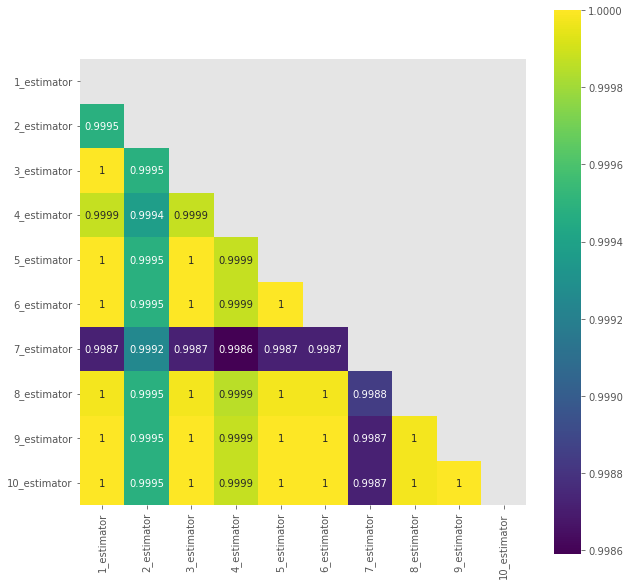

In [362]:
scores = pd.DataFrame({
    f"{i}_estimator": preds for i, preds in enumerate(predictions, 1)
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()
# cannot use ensemble

In [686]:
from xgboost import XGBClassifier

xg_params = {
        "booster": "gbtree",
        # "scale_pos_weight": np.sum(y==0)/np.sum(y==1),
        "n_estimators": 100,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": 0.0145,
        "reg_lambda": 10,
        "min_child_weight": 100,
        "max_depth": 5,
        "gamma": 10,
        "nthread": -1,
        "seed": seed,
}
_, _, _, _, oof_xgb = make_modify_cross_validation(
    X[selected], 
    y, 
    XGBClassifier(**xg_params), 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5158, valid-score = 0.5223
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5156, valid-score = 0.5235
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5154, valid-score = 0.5256
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5163, valid-score = 0.5181
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5172, valid-score = 0.5099
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5174, valid-score = 0.5078
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5165, valid-score = 0.5155
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5167, valid-score = 0.5139
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5165, valid-score = 0.5163
Fold: 10, train-observations = 76058, valid-ob

In [687]:
xg_model = XGBClassifier(**xg_params).fit(X_train[selected], y_train)
roc_auc_score(y_test, xg_model.predict_proba(X_test[selected])[:,1])

0.5154557365249604

In [688]:
scores = create_bootstrap_metrics(y_test, xg_model.predict_proba(X_test[selected])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.5086512055386762, 0.5227061507499928)

In [689]:
from catboost import CatBoostClassifier

cb_params = {
        "n_estimators": 100,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "max_depth": 3,
        "learning_rate": 0.005,
        "l2_leaf_reg": 100,
        "grow_policy": "SymmetricTree",
        "boosting_type": "Plain",
        "auto_class_weights": "SqrtBalanced",
        "silent": True,
        "allow_writing_files": False,
        "subsample": 0.8,
        "colsample_bylevel": 0.8,
        "random_seed": seed
    }

_, _, _, _, oof_cat = make_modify_cross_validation(
    X[selected], 
    y, 
    CatBoostClassifier(**cb_params), 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.517, valid-score = 0.5154
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5202, valid-score = 0.5138
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5184, valid-score = 0.512
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5197, valid-score = 0.5164
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.519, valid-score = 0.5026
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5201, valid-score = 0.5085
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5198, valid-score = 0.5089
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5192, valid-score = 0.5113
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5206, valid-score = 0.5027
Fold: 10, train-observations = 76058, valid-obser

In [690]:
cb_model = CatBoostClassifier(**cb_params).fit(X_train[selected], y_train)
roc_auc_score(y_test, cb_model.predict_proba(X_test[selected])[:,1])

0.5146014595814477

In [691]:
scores = create_bootstrap_metrics(y_test, cb_model.predict_proba(X_test[selected])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.4995395247146829, 0.5290981925516517)

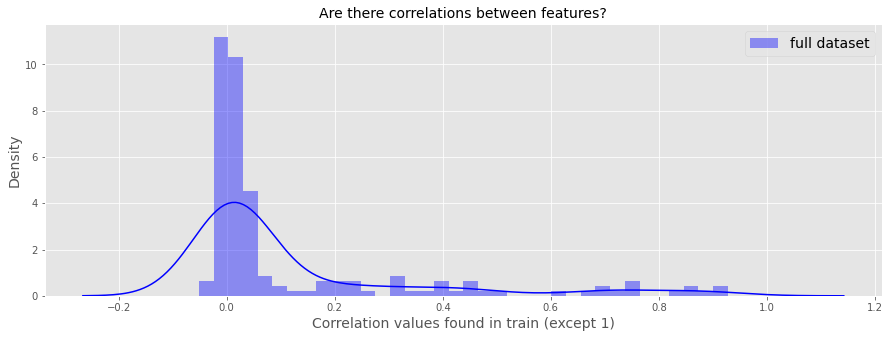

In [516]:
train_correlations = X_train[selected].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = X_train[selected].columns.tolist()

plt.figure(figsize=(15,5))
sns.distplot(train_correlations, color="Blue", label="full dataset")  # better to check on train/test 

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

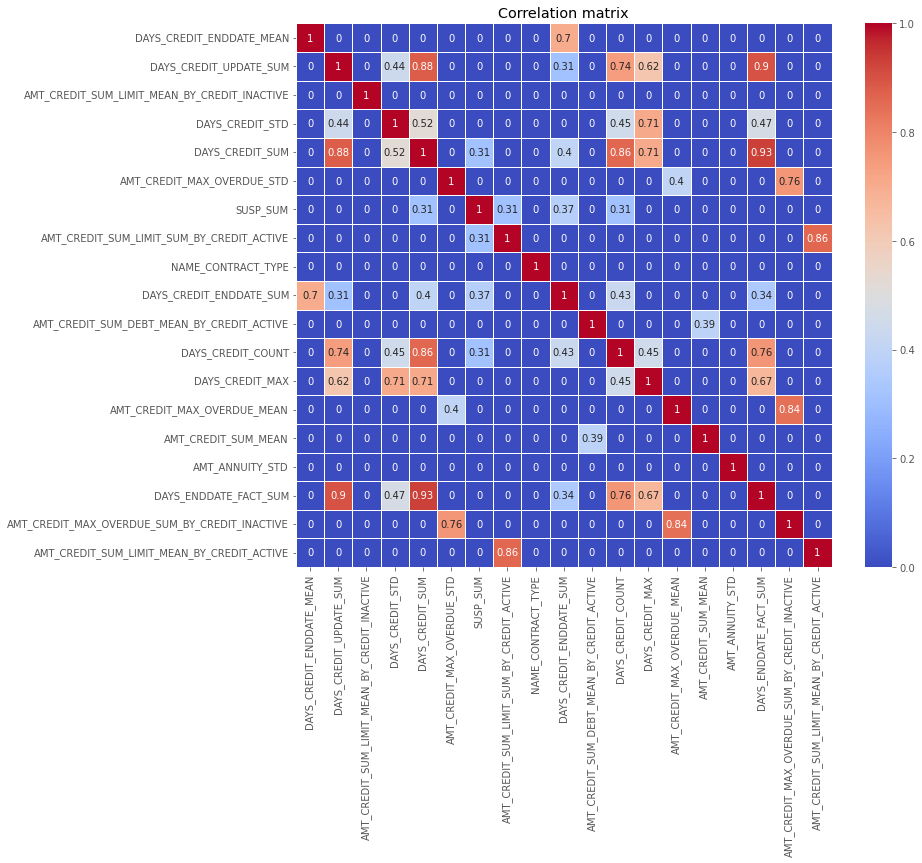

In [517]:
plt.figure(figsize = (12,10))
corr_matrix = X_train[selected].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # not significant correlation
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [692]:
logreg_pca = make_pipeline(StandardScaler(), 
                           PCA(n_components=17, random_state=seed),  # as to explained variance
                           PolynomialFeatures(degree=2, interaction_only=False),
                           LogisticRegression(class_weight='balanced',
                                                            solver='liblinear',
                                                            random_state=seed, 
                                                            penalty='l1', 
                                                            C=0.001,
                                                            n_jobs=-1))

_, _, _, _, oof_log = make_modify_cross_validation(
    X[selected], 
    y, 
    logreg_pca, 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5222, valid-score = 0.5375
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.527, valid-score = 0.5245
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5245, valid-score = 0.5298
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5234, valid-score = 0.5155
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5245, valid-score = 0.5114
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5264, valid-score = 0.5043
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5278, valid-score = 0.5134
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5237, valid-score = 0.5194
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5241, valid-score = 0.5369
Fold: 10, train-observations = 76058, valid-obs

In [693]:
roc_auc_score(y_test, logreg_pca.predict_proba(X_test[selected])[:,1])

0.5177222460182301

In [694]:
scores = create_bootstrap_metrics(y_test, logreg_pca.predict_proba(X_test[selected])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.5031740049276764, 0.5332756551164901)

In [557]:
predictions = [estimator.predict_proba(X_test[selected])[:,1] for estimator in (logreg_pca, model, xg_model, cb_model)]
predictions = pd.DataFrame(data=predictions)

In [561]:
mean_scores(predictions.T, y_test)  # rank - the most strong

AMean score: 0.51605
GMean score: 0.51535
Rank  score: 0.51661
GMean  rank: 0.51530


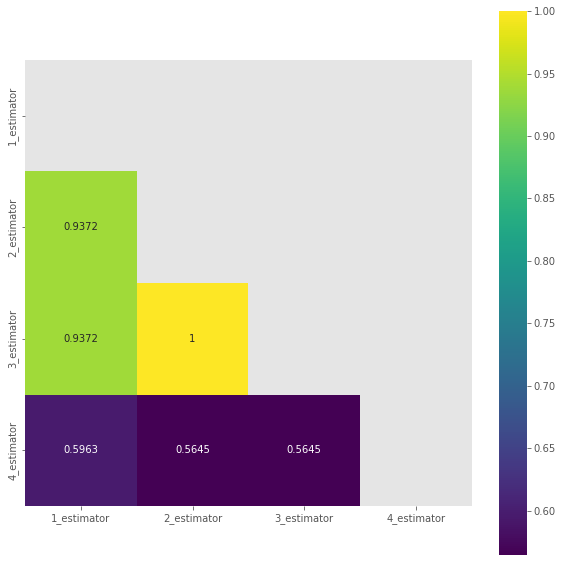

In [572]:
scores = pd.DataFrame({
    f"{i}_estimator": preds for i, preds in enumerate(predictions.values, 1)
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [582]:
%%time
stack = StackingClassifier(estimators=[('logreg', make_pipeline(StandardScaler(), 
                                                                PCA(n_components=17, random_state=seed),
                                                                PolynomialFeatures(degree=2, interaction_only=False),
                                                                LogisticRegression(class_weight='balanced',
                                                                                   solver='liblinear',
                                                                                   random_state=seed, 
                                                                                   penalty='l1', 
                                                                                   C=0.01,
                                                                                   n_jobs=-1))),
                                       ('lgbm', LGBMClassifier(**params)),
                                       ('xgboost', XGBClassifier(**xg_params)),
                                       ('catboost', CatBoostClassifier(**cb_params))],  
                           cv=10, 
                           stack_method='predict_proba',  
                           n_jobs=-1,  
                           passthrough=False,
                           final_estimator=LogisticRegression(random_state=seed, n_jobs=-1, C=0.01)
                          ).fit(X_train[selected], y_train)  

CPU times: total: 2.42 s
Wall time: 16min 17s


In [576]:
_, _, _, _, oof_log = make_modify_cross_validation(
    X[selected], 
    y, 
    stack, 
    metric=roc_auc_score, 
    cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
    error_to_be_outlier=False
)

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5225, valid-score = 0.538
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5293, valid-score = 0.5227
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5246, valid-score = 0.5294
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5245, valid-score = 0.5149
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5247, valid-score = 0.5113
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5265, valid-score = 0.5052
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5291, valid-score = 0.513
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5247, valid-score = 0.518
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.5243, valid-score = 0.5362
Fold: 10, train-observations = 76058, valid-obser

In [583]:
print(roc_auc_score(y_train, stack.predict_proba(X_train[selected])[:,1]))
roc_auc_score(y_test, stack.predict_proba(X_test[selected])[:,1])

0.5424182205963177


0.5206286351149486

In [584]:
scores = create_bootstrap_metrics(y_test, stack.predict_proba(X_test[selected])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.5059633190240674, 0.5362179763207882)

In [585]:
roc_auc_score(y_test, np.prod(predictions, axis=0)**(1/4))  # root

0.5153500890923469

In [ ]:
# plot cm for oof scores
# train estimators get oof. train final on oof and y, use stack with cv

In [591]:
oof_predictions = pd.DataFrame(data={'log': oof_log, 'lgbm': oof_lgbm, 'xgb': oof_xgb, 'cat': oof_cat}, index=y.index)

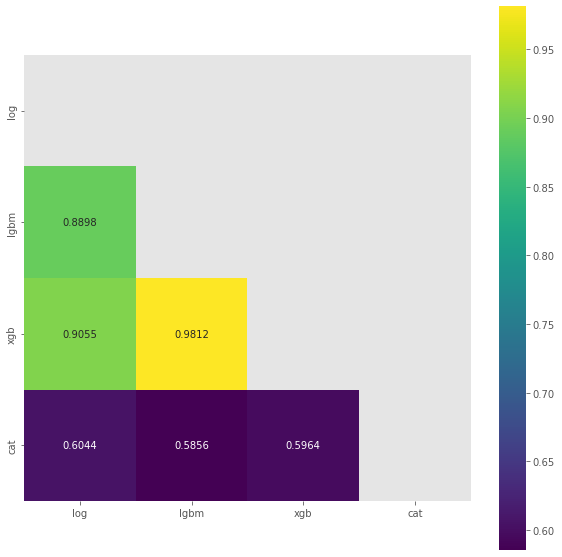

In [592]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [595]:
mean_scores(oof_predictions, y)

AMean score: 0.51396
GMean score: 0.51286
Rank  score: 0.51143
GMean  rank: 0.51087


In [597]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

lda_estimators, _, _, _, _ = make_modify_cross_validation(
                                                          oof_predictions, 
                                                          y, 
                                                          lda, 
                                                          metric=roc_auc_score, 
                                                          cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                                                          error_to_be_outlier=False
                                                          )

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.5112, valid-score = 0.5116
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5131, valid-score = 0.5275
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5095, valid-score = 0.5072
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5161, valid-score = 0.5169
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5137, valid-score = 0.5155
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5108, valid-score = 0.5088
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5131, valid-score = 0.5136
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5099, valid-score = 0.5141
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.512, valid-score = 0.5068
Fold: 10, train-observations = 76058, valid-obs

In [621]:
x_test_lda = pd.DataFrame(data=np.array([model.predict_proba(predictions.T)[:,1] for model in lda_estimators]).T, 
                          columns=[f"lda_{i}" for i in range(1,11)], index=y_test.index)

In [624]:
mean_scores(x_test_lda, y_test)

AMean score: 0.51541
GMean score: 0.51544
Rank  score: 0.51402
GMean  rank: 0.51368


In [629]:
roc_auc_score(y_test, np.prod(x_test_lda, axis=1)**(1/10))

0.5154352321987808

In [632]:
scores = create_bootstrap_metrics(y_test, stats.gmean(x_test_lda, axis=1), roc_auc_score)

calculate_confidence_interval(scores)

(0.5006431342326695, 0.5293805349134462)

In [639]:
lg = LogisticRegression(class_weight='balanced', n_jobs=-1, solver='liblinear', penalty='l1', random_state=seed, C=0.1)

lg_estimators, _, _, _, oof_lg_stack = make_modify_cross_validation(
                                                          oof_predictions, 
                                                          y, 
                                                          lg, 
                                                          metric=roc_auc_score, 
                                                          cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                                                          error_to_be_outlier=False
                                                          )

Fold: 1, train-observations = 76057, valid-observations = 8451
train-score = 0.514, valid-score = 0.5378
Fold: 2, train-observations = 76057, valid-observations = 8451
train-score = 0.5191, valid-score = 0.5245
Fold: 3, train-observations = 76057, valid-observations = 8451
train-score = 0.5185, valid-score = 0.5299
Fold: 4, train-observations = 76057, valid-observations = 8451
train-score = 0.5173, valid-score = 0.5141
Fold: 5, train-observations = 76057, valid-observations = 8451
train-score = 0.5177, valid-score = 0.5116
Fold: 6, train-observations = 76057, valid-observations = 8451
train-score = 0.5185, valid-score = 0.5045
Fold: 7, train-observations = 76057, valid-observations = 8451
train-score = 0.5167, valid-score = 0.5121
Fold: 8, train-observations = 76057, valid-observations = 8451
train-score = 0.5171, valid-score = 0.5198
Fold: 9, train-observations = 76058, valid-observations = 8450
train-score = 0.515, valid-score = 0.5371
Fold: 10, train-observations = 76058, valid-obse

In [640]:
x_test_lgr = pd.DataFrame(data=np.array([model.predict_proba(predictions.T)[:,1] for model in lg_estimators]).T, 
                          columns=[f"lg_{i}" for i in range(1,11)], index=y_test.index)

In [642]:
mean_scores(x_test_lgr, y_test)

AMean score: 0.51801
GMean score: 0.51801
Rank  score: 0.51800
GMean  rank: 0.51805


In [643]:
scores = create_bootstrap_metrics(y_test, stats.gmean(x_test_lgr.rank(), axis=1), roc_auc_score)

calculate_confidence_interval(scores)

(0.5034667123218147, 0.533398419845786)

In [695]:
# use 4 estimators to obtain scores, use logreg to predict_proba test labels, ranked gmean in ensemble

#### test data

In [ ]:
test_bki = prepare_bki(bki, list(test_ids))
test_data = test.merge(test_bki, on=ID_COL, how='left')
test_data.set_index(ID_COL, inplace=True)
test_data = test_data[selected]
test_data.dropna(inplace=True)
test_data['NAME_CONTRACT_TYPE'] = test_data['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

<AxesSubplot:>

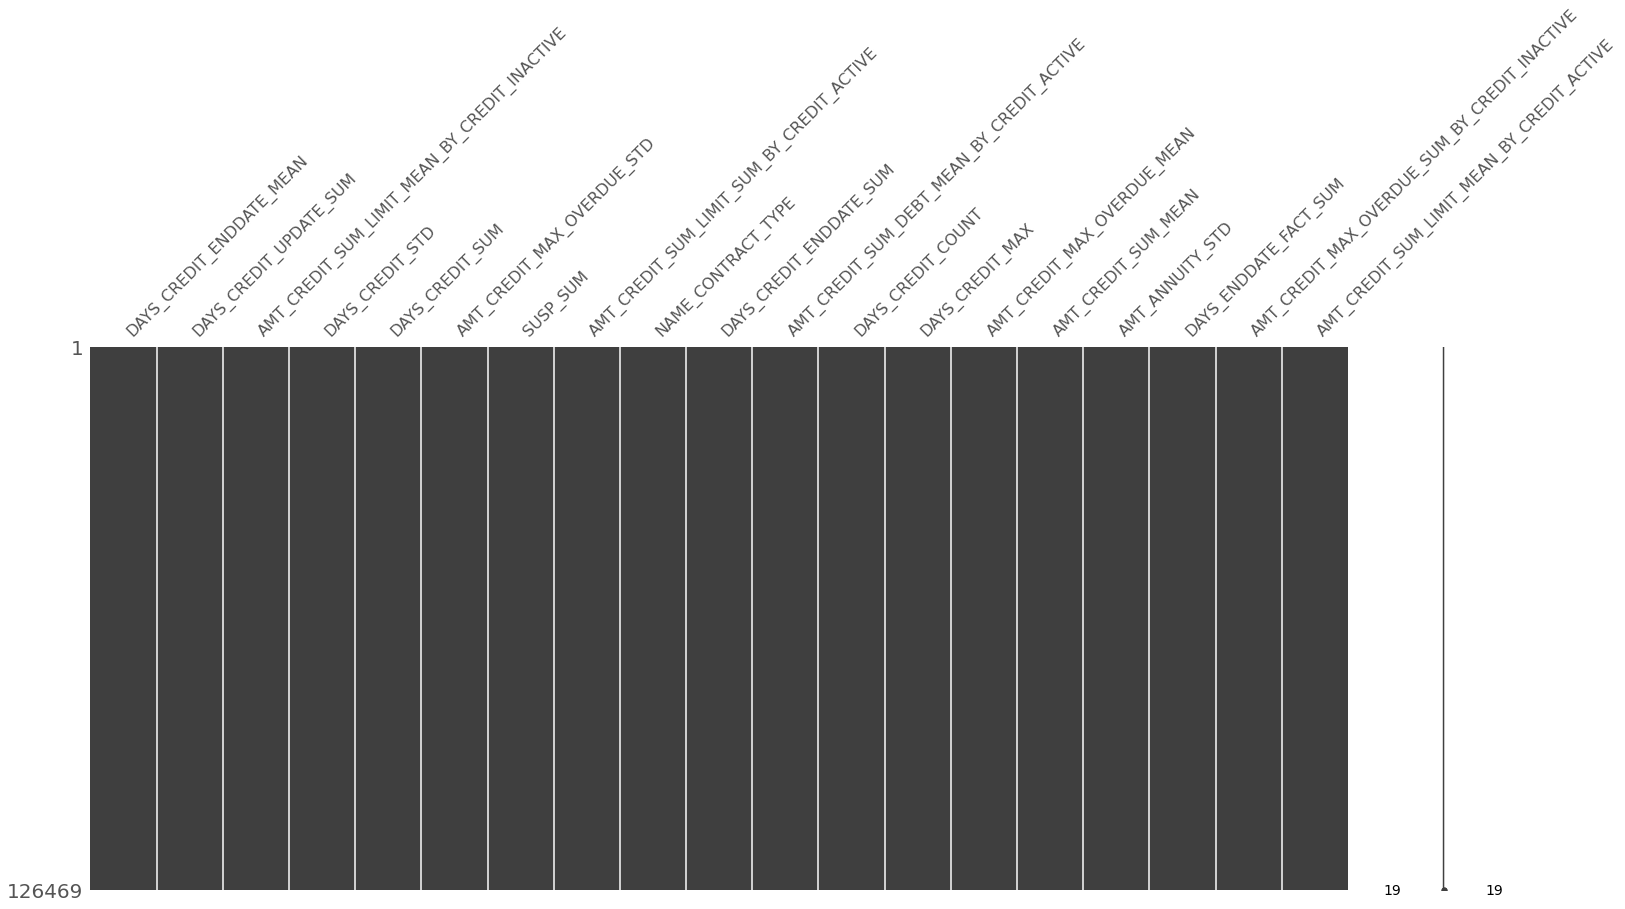

In [394]:
msno.matrix(test_data)

In [403]:
X_inspect = pd.concat([test_data, X[selected]], axis=0)
y_inspect = np.hstack((np.ones(test_data.shape[0]), np.zeros(X.shape[0])))

model = LGBMClassifier( max_depth=3, 
                        n_estimators=100,
                        verbose=-1,
                        is_unbalance=True,
                        learning_rate=0.01,   
                        random_seed=seed)
model.fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=model,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.4988


### Profile

In [406]:
cp.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,250000.0000,250000.0000,250000.0000,250000.0000,249989.0000,250000.0000,250000.0000,250000.0000,85041.0000,250000.0000,250000.0000,249998.0000,109121.0000,249468.0000,200462.0000,216293.0000,216293.0000,216293.0000,216293.0000,216293.0000,216293.0000
mean,123577106.0131,0.4176,169066.1513,599305.1255,27125.2096,0.0209,16033.4605,67505.8833,12.0302,0.2802,0.0571,2.1540,0.5021,0.5142,0.5108,0.0063,0.0069,0.0342,0.2675,0.2668,1.8990
std,88777.2224,0.7225,258847.9858,402272.0241,14503.9304,0.0138,4361.3323,139261.0996,11.8994,0.4491,0.2320,0.9115,0.2108,0.1911,0.1951,0.0838,0.1080,0.2040,0.9145,0.8315,1.8688
min,123423341.0000,0.0000,25650.0000,45000.0000,1615.5000,0.0003,7489.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0147,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,123500214.5000,0.0000,112500.0000,270000.0000,16524.0000,0.0100,12415.0000,931.0000,5.0000,0.0000,0.0000,2.0000,0.3342,0.3920,0.3706,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,123577184.5000,0.0000,148500.0000,514777.5000,24930.0000,0.0188,15744.0000,2217.0000,9.0000,0.0000,0.0000,2.0000,0.5060,0.5657,0.5353,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,123653961.2500,1.0000,202500.0000,808650.0000,34618.5000,0.0287,19681.0000,5678.0000,15.0000,1.0000,0.0000,3.0000,0.6748,0.6635,0.6691,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
max,123730851.0000,19.0000,117000000.0000,4050000.0000,230161.5000,0.0725,25229.0000,365243.0000,69.0000,1.0000,1.0000,20.0000,0.9627,0.8550,0.8960,4.0000,9.0000,8.0000,27.0000,261.0000,25.0000


In [408]:
cp.duplicated().sum()

0

In [409]:
for column in cp.columns:
    if cp[column].nunique() < 2:
        print(column)

<AxesSubplot:>

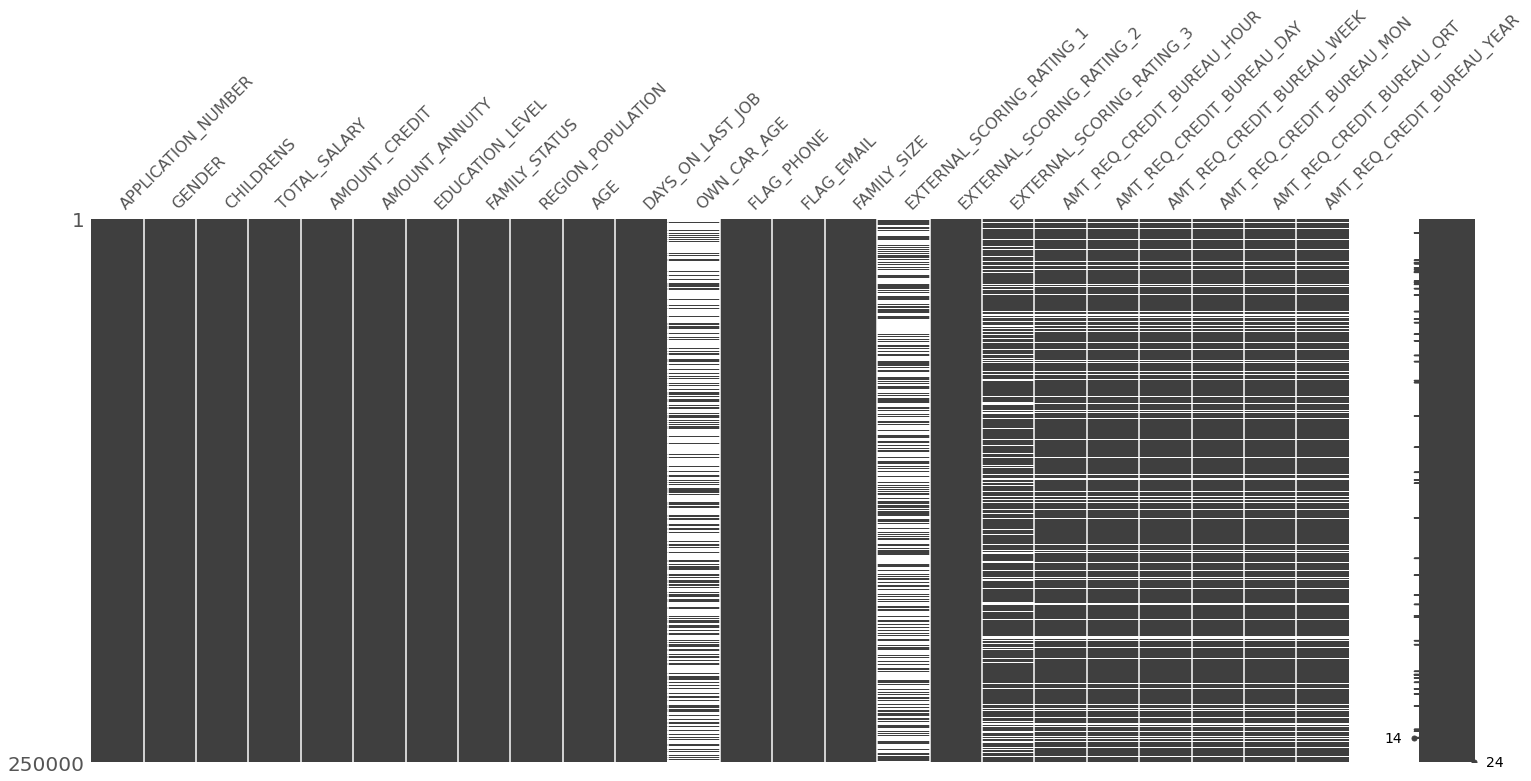

In [410]:
#missing / outliers
msno.matrix(cp)

In [413]:
len(cp_ids & train_ids), len(cp_ids & bki_ids), len(train_ids & (cp_ids & bki_ids))

(89539, 191604, 68723)

<AxesSubplot:>

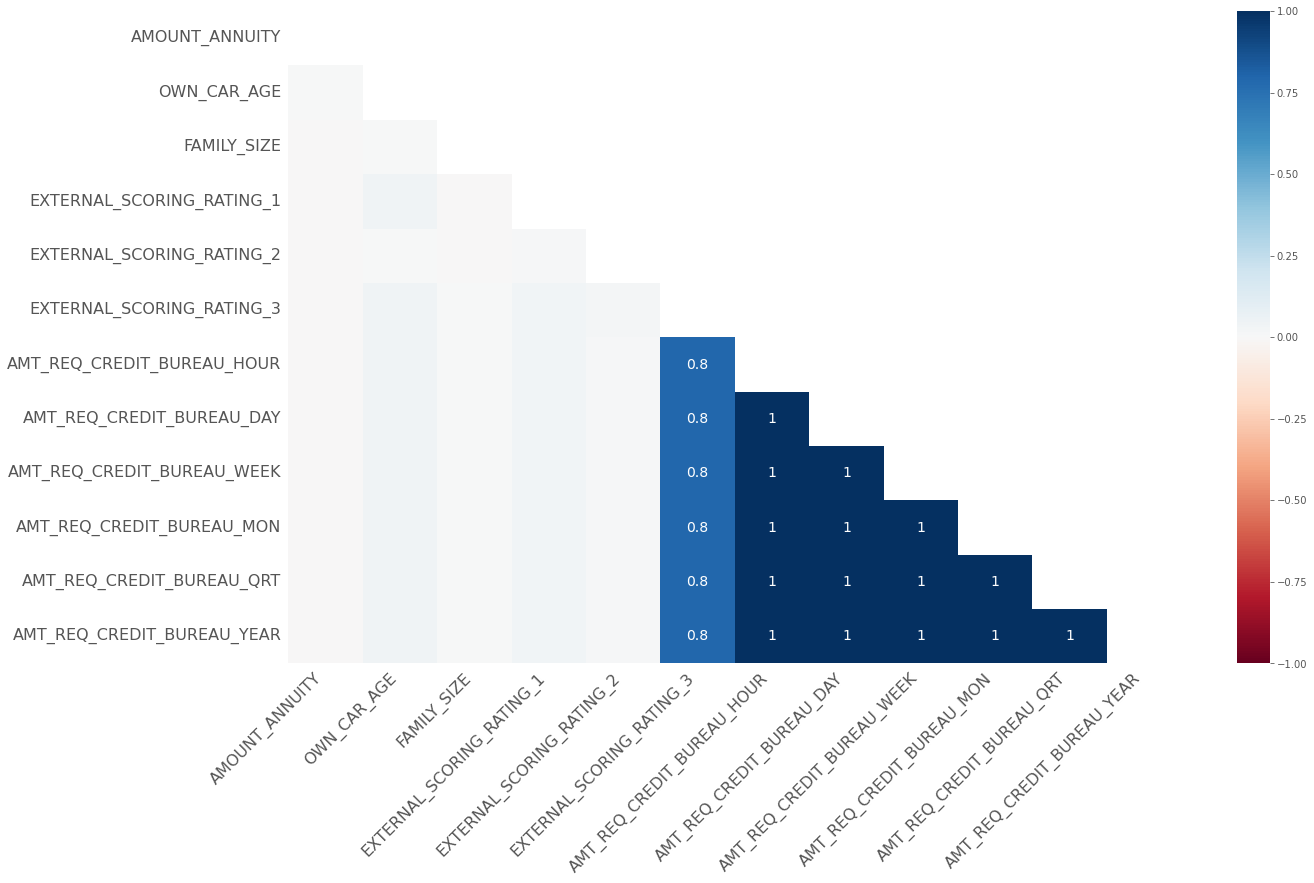

In [414]:
msno.heatmap(cp)

In [418]:
check_missings(cp)

Total NA-values = 558163


,AMOUNT_ANNUITY,OWN_CAR_AGE,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,11,164959,2,140879,532,49538,33707,33707,33707,33707,33707,33707
Percent,0.0044,65.9836,0.0008,56.3516,0.2128,19.8152,13.4828,13.4828,13.4828,13.4828,13.4828,13.4828
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [419]:
cp.fillna(0, inplace=True)

In [420]:
cp.shape[0], cp[ID_COL].nunique()

(250000, 250000)

In [422]:
cp.describe(include="object")

,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
count,250000,250000,250000
unique,3,5,6
top,F,Secondary / secondary special,Married
freq,164645,177562,159846


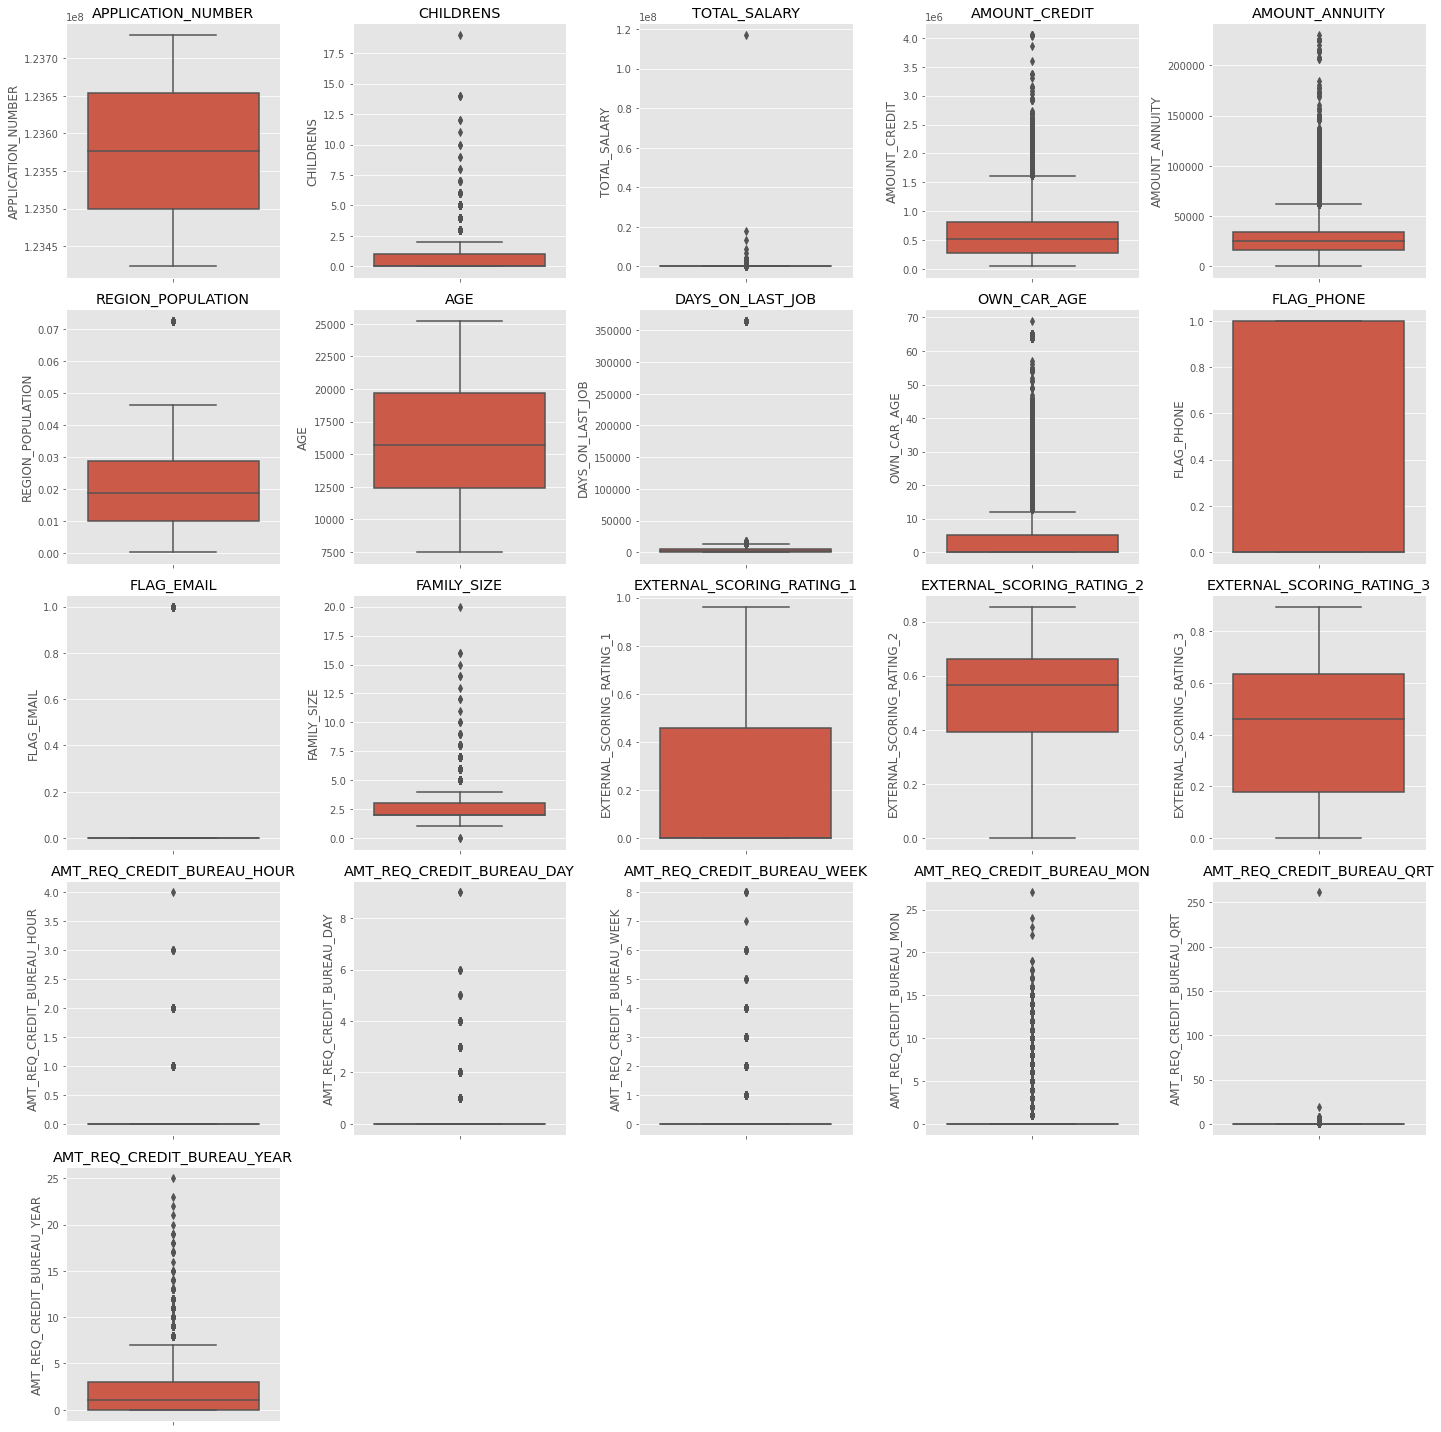

In [446]:
# log for outliers
numerical_columns = cp.select_dtypes("number").columns
plt.figure(figsize=(20,20))
for idx, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 5, idx)
    sns.boxplot(y=cp[column], data=cp)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

In [646]:
# single point inspectation (dealing) + new feature based on IQR?
### cp[cp.AMT_REQ_CREDIT_BUREAU_QRT > 50] -> cp[cp.AMT_REQ_CREDIT_BUREAU_QRT <= 50].max() + 1
### cp[cp.DAYS_ON_LAST_JOB > 50000] -> 365.25
    # cp.REGION_POPULATION.hist(bins=10) OK - big cities
    # CHILDREN corresponds to FAMILY_SIZE
### cp[cp.TOTAL_SALARY < 1e+8]['TOTAL_SALARY'] /= 1000
cp[cp.TOTAL_SALARY > 1e+8]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
146538,123436181,F,1,117000000.0000,562491.0000,26194.5000,Secondary / secondary special,Married,0.0106,12615,922,0.0000,0,0,3.0000,0.4608,0.1132,0.1455,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [475]:
for column in cp.select_dtypes(include="object").columns:
    print(cp[column].value_counts(), '\n', '='*40)
# replace XNA with mode
# education: catboost target encoding df[edu] = ce.fit_transform/transform(df[edu], TARGET) (target from train)
# family status: union unknown with civil marriage

F      164645
M       85351
XNA         4
Name: GENDER, dtype: int64 
Secondary / secondary special    177562
Higher education                  60864
Incomplete higher                  8357
Lower secondary                    3081
Academic degree                     136
Name: EDUCATION_LEVEL, dtype: int64 
Married                 159846
Single / not married     36883
Civil marriage           24252
Separated                15984
Widow                    13033
Unknown                      2
Name: FAMILY_STATUS, dtype: int64 


In [1475]:
def prepare_cp(labels: pd.DataFrame, dropna: bool = True, create_features: bool = False) -> pd.DataFrame:
    df = pd.read_csv('client_profile.csv')
    # fill missing values: 0 is reasonable
    df.fillna(0, inplace=True)

    # deal with extreme outliers
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 50] = df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] <= 50, 'AMT_REQ_CREDIT_BUREAU_QRT'].max() + 1
    df.loc[df['DAYS_ON_LAST_JOB'] > 50000, 'DAYS_ON_LAST_JOB'] = 366
    df.loc[df['TOTAL_SALARY'] > 1e+8, 'TOTAL_SALARY'] /= 1000.

    # IQR mark
    df['IS_OUTLIER'] = 0
    for column in df.select_dtypes(include="number").columns:
        q1, q3 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        condition = ((df[column] > upper_bound) | (df[column] < lower_bound))
        df.loc[condition, 'IS_OUTLIER'] = 1

    # transform categorical columns
    df.loc[df['GENDER'] == 'XNA', 'GENDER'] = df['GENDER'].mode()[0]
    df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
    df.loc[df['FAMILY_STATUS'] == 'Unknown', 'FAMILY_STATUS'] = 'Civil marriage'
    
    df['AGE'] = df['AGE'] / 365.25
    df['AGE_BIN'] = pd.cut(df['AGE'], bins=np.linspace(18, 70, 10), labels=False) + 1
    
    df = pd.merge(labels, df, on=ID_COL, how='left')
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

    if dropna:
        df.dropna(subset=df.columns.tolist()[3:], inplace=True) 
    if create_features:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / (df['AMOUNT_ANNUITY'] + 1)
        df['NEW_STATUS'] = df['GENDER'].map({0: 'F', 1: 'M'}) + df['FAMILY_STATUS'].astype(str)
        df["RATIO_ANNUITY_TO_AGE"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["RATIO_CREDIT_TO_AGE"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["RATIO_SALARY_TO_AGE"] = df["TOTAL_SALARY"] / df["AGE"]
        df["RATIO_AGE_TO_EXPERIENCE"] = df["AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df["RATIO_CAR_TO_EXPERIENCE"] = df["OWN_CAR_AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df["RATIO_CAR_TO_AGE"] = df["OWN_CAR_AGE"] / df["AGE"]
        aggs = {
                "TOTAL_SALARY": ["mean", "max", "min", "count"],
                "AMOUNT_CREDIT": ["mean", "max", "min", "count"],
                "AMOUNT_ANNUITY": ["mean", "max", "min", "count"]
                }

        stat = create_numerical_aggs(df, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION")
        df = df.merge(stat, on='EDUCATION_LEVEL', how='left')
        df["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] / (df["TOTAL_SALARY_MEAN_BY_EDUCATION"] + 1)
        df["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] - df["TOTAL_SALARY_MEAN_BY_EDUCATION"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT"] = df["TOTAL_SALARY"] / df["AMOUNT_CREDIT"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY"] = df["TOTAL_SALARY"] / (df["AMOUNT_CREDIT"] / (df["FAMILY_SIZE"] + 1))
        df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = df["AMOUNT_ANNUITY"] / (df["TOTAL_SALARY"]) # redundant
        df["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = df["TOTAL_SALARY"] / (df["FAMILY_SIZE"] + 1)
        df["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.3, 1, 0)
        df["EDUCATION_FAMILY_STATUS"] = df["EDUCATION_LEVEL"] + " | " + df["FAMILY_STATUS"]
        stat = create_numerical_aggs(df, groupby_id="AGE_BIN", aggs=aggs, suffix="_AGE_INTERVAL")
        df = df.merge(stat, on='AGE_BIN', how='left')
        stat = create_numerical_aggs(df, groupby_id="FAMILY_STATUS", aggs=aggs, suffix="_BY_FAMILY_STATUS")
        df = df.merge(stat, on='FAMILY_STATUS', how='left')

        aggs = {"NEW_CREDIT_TO_ANNUITY_RATIO": ["mean"],
                "RATIO_SALARY_TO_AMOUNT_CREDIT": ["mean"]}
        stat = create_numerical_aggs(df, groupby_id=["GENDER", "AGE_BIN"], aggs=aggs, suffix="_GENDER_AGE_BIN")
        df = df.merge(stat, on=["GENDER", "AGE_BIN"], how='left')
        df['EXT_SCORE_1_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_2_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_3_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_CREDIT']
        
        df['EXT_SCORE_1_ANNUITY'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_2_ANNUITY'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_3_ANNUITY'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_ANNUITY']
        
        df['SALARY_REGION_POPULATION'] = df['TOTAL_SALARY'] * df['REGION_POPULATION']
        df['SALARY_JOB'] = df['TOTAL_SALARY'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df['CREDIT_JOB'] = df['AMOUNT_CREDIT'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df['ANNUITY_JOB'] = df['AMOUNT_ANNUITY'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        funcs = ["min", "max", "mean", "nanmedian", "var"]
        for func in funcs:
            df[f"EXT_SCORES_{func}"] = eval("np.{}".format(func))(df[['EXTERNAL_SCORING_RATING_1',
                                                                      'EXTERNAL_SCORING_RATING_2',
                                                                      'EXTERNAL_SCORING_RATING_3']], axis=1)

    df = reduce_memory_df(df)
    df.set_index(ID_COL, inplace=True)

    return df

In [1391]:
data.shape, len((train_ids | test_ids) & cp_ids), data_train.shape, data_test.shape

((223714, 96), 223715, (89539, 96), (134175, 96))

In [1476]:
data = pd.concat([train, test], axis=0)
data = prepare_cp(data, create_features=True, dropna=True)
train_bound = len(data) - data[TARGET].isna().sum()

Memory usage of dataframe is 166.41 MB
Memory usage after optimization is: 80.65 MB
Decreased by 51.5%


In [1477]:
# data_train, data_test = data[~data[TARGET].isna()], data[data[TARGET].isna()]
data_train, data_test = data.iloc[:train_bound, :], data.iloc[train_bound:, :]
data_train[TARGET] = data_train[TARGET].astype(int)

In [1478]:
data_train[TARGET].value_counts(normalize=True)

0   0.9195
1   0.0805
Name: TARGET, dtype: float64

In [1479]:
x_train, x_test, y_learn, y_valid = train_test_split(data_train.drop(TARGET, axis=1), data_train[TARGET], 
                                                     test_size=0.2, shuffle=True,
                                                     random_state=seed)

In [1480]:
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed)
model.fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=model,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

# the split is ok

CV-score: 0.5


In [1448]:
x_train.describe(include="category")

,EDUCATION_LEVEL,FAMILY_STATUS,NEW_STATUS,EDUCATION_FAMILY_STATUS
count,88074,88074,88074,88074
unique,5,5,10,25
top,Secondary / secondary special,Married,FMarried,Secondary / secondary special | Married
freq,62417,56171,35067,39854


In [1481]:
# WoE for x_train | catboost
encoder = ce.woe.WOEEncoder(random_state=seed)
x_train[['EDUCATION_LEVEL', 'FAMILY_STATUS', 'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']] = \
        encoder.fit_transform(x_train[['EDUCATION_LEVEL', 'FAMILY_STATUS', 
                                       'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']], y_learn)
x_test[['EDUCATION_LEVEL', 'FAMILY_STATUS', 'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']] = \
        encoder.transform(x_test[['EDUCATION_LEVEL', 'FAMILY_STATUS', 
                                   'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']])

In [1290]:
boruta_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'is_unbalance': True,
                'n_estimators': 150,
                'learning_rate': 0.01,
                'min_child_weight': 600,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 25,
                'reg_lambda': 25,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'random_state': seed
}

selector = BorutaShap(model=LGBMClassifier(**boruta_params), importance_measure='shap', classification=True)
selector.fit(x_train, y_learn, n_trials=25, sample=True, normalize=True, verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

38 attributes confirmed important: ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 'ANNUITY_JOB', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_2_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXT_SCORES_mean', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXT_SCORE_1_AMT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_nanmedian', 'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'EXT_SCORE_2_ANNUITY', 'EXT_SCORES_max', 'EXT_SCORES_var', 'EXT_SCORES_min', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'NEW_STATUS', 'AMOUNT_CREDIT']
45 attributes confirmed unimportant: ['C

In [1300]:
features = ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'RATIO_CREDIT_TO_AGE', 
            'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 
            'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 
            'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'OWN_CAR_AGE', 'AMOUNT_ANNUITY_COUNT_AGE_INTERVAL', 
            'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_LEVEL', 
            'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'REGION_POPULATION', 'RATIO_ANNUITY_TO_AGE', 
            'NEW_CREDIT_TO_ANNUITY_RATIO', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_1', 
            'AGE_BIN', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'NEW_STATUS', 
            'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'TOTAL_SALARY_MEAN_BY_FAMILY_STATUS', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 
            'TOTAL_SALARY', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 
            'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS', 'RATIO_SALARY_TO_AGE', 
            'FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 'RATIO_CAR_TO_EXPERIENCE']

features = ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 'ANNUITY_JOB', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 
            'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_2_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 
            'EXT_SCORES_mean', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
            'EXT_SCORE_1_AMT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'EXT_SCORE_3_AMT_CREDIT', 
            'EXT_SCORES_nanmedian', 'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'EXT_SCORE_2_ANNUITY', 'EXT_SCORES_max', 
            'EXT_SCORES_var', 'EXT_SCORES_min', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 
            'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 
            'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 
            'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'NEW_STATUS', 'AMOUNT_CREDIT', 'OWN_CAR_AGE', 'REGION_POPULATION', 
            'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 
            'AMOUNT_ANNUITY_COUNT_BY_EDUCATION', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 
            'TOTAL_SALARY_MIN_AGE_INTERVAL', 'SALARY_JOB', 'AMOUNT_ANNUITY', 'RATIO_SALARY_TO_AGE']

**LGBM**

In [1533]:
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 200, 
                'learning_rate': 0.05, 
                'min_child_weight': 650, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

lgbm_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_lgbm = make_modify_cross_validation(
        x_train[features], 
        y_learn, 
        LGBMClassifier(**lgbm_params), 
        metric=roc_auc_score, 
        cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
        error_to_be_outlier=False,
        early=False
        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7671, valid-score = 0.7658
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7687, valid-score = 0.7501
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7695, valid-score = 0.7458
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7686, valid-score = 0.753
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7683, valid-score = 0.7503
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7695, valid-score = 0.7416
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7697, valid-score = 0.7429
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7683, valid-score = 0.7535
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7678, valid-score = 0.7543
Fold: 10, train-observations = 64468, valid-obs

In [1534]:
lgbm = LGBMClassifier(**lgbm_params).fit(x_train[features], y_learn)
valid_lgbm_predictions = lgbm.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, lgbm.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, lgbm.predict_proba(x_test[features])[:,1]))

0.7672399564739565
0.7516373903862517


In [1535]:
scores = create_bootstrap_metrics(y_valid, lgbm.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7388627721331597, 0.7643936086485015)

**XGBoost**

In [1536]:
xg_params = {
        "booster": "gbtree",
        # "scale_pos_weight": np.sum(y==0)/np.sum(y==1),
        "n_estimators": 200,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": 0.05,
        "reg_lambda": 10,
        "min_child_weight": 600,
        "colsample_bylevel": 0.8,
        "max_depth": 4,
        "gamma": 10,
        "nthread": -1,
        "grow_policy": "depthwise",
        "seed": seed,
}
xgb_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_xgb = make_modify_cross_validation(
                            x_train[features], 
                            y_learn, 
                            XGBClassifier(**xg_params), 
                            metric=roc_auc_score, 
                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                            error_to_be_outlier=False
                        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7529, valid-score = 0.7622
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.753, valid-score = 0.7406
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7551, valid-score = 0.7359
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7547, valid-score = 0.7442
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7541, valid-score = 0.7407
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7557, valid-score = 0.7344
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7555, valid-score = 0.7322
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7539, valid-score = 0.7419
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7539, valid-score = 0.7386
Fold: 10, train-observations = 64468, valid-obs

In [1537]:
xgb = XGBClassifier(**xg_params).fit(x_train[features], y_learn)
valid_xgb_predictions = xgb.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, xgb.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, xgb.predict_proba(x_test[features])[:,1]))

0.7567557936296271
0.7424985989516812


In [1538]:
scores = create_bootstrap_metrics(y_valid, xgb.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7297199771442415, 0.7557449048001685)

**Logreg**

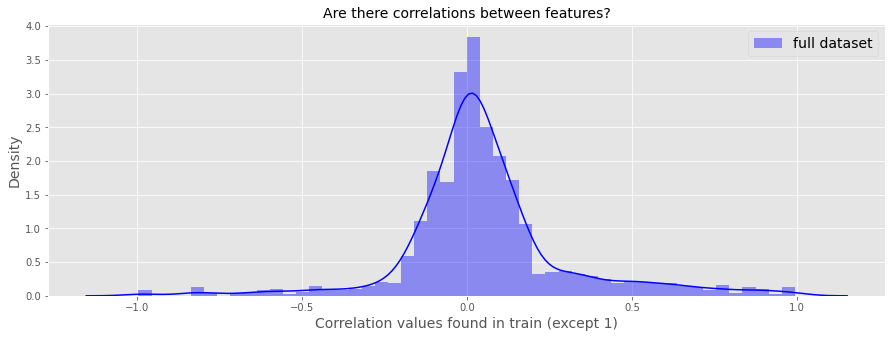

In [1539]:
train_correlations = x_train[features].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = X_train[selected].columns.tolist()

plt.figure(figsize=(15,5))
sns.distplot(train_correlations, color="Blue", label="full dataset")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

In [1540]:
logreg = make_pipeline(StandardScaler(),
                       PCA(n_components=x_train[features].shape[1]-5, random_state=seed),
                       LogisticRegression(class_weight='balanced', 
                                          solver='liblinear', 
                                          penalty='l1', 
                                          C=10,
                                          random_state=seed,
                                          n_jobs=-1))

log_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_log = make_modify_cross_validation(
                            x_train[features], 
                            y_learn, 
                            logreg, 
                            metric=roc_auc_score, 
                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                            error_to_be_outlier=False
                        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7245, valid-score = 0.7438
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7262, valid-score = 0.7279
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7271, valid-score = 0.7189
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.727, valid-score = 0.7215
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7272, valid-score = 0.7177
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7278, valid-score = 0.7145
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7274, valid-score = 0.7177
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7265, valid-score = 0.7264
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7272, valid-score = 0.7187
Fold: 10, train-observations = 64468, valid-obs

In [1541]:
logreg = logreg.fit(x_train[features], y_learn)
valid_log_predictions = logreg.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, logreg.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, logreg.predict_proba(x_test[features])[:,1]))

0.7265344638194042
0.7247908002842712


In [1542]:
scores = create_bootstrap_metrics(y_valid, logreg.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7115792895125729, 0.737306074606931)

**catboost**

In [1543]:
# preserve cat features
x_train, x_test, y_learn, y_valid = train_test_split(data_train.drop(TARGET, axis=1), data_train[TARGET], 
                                                     test_size=0.2, shuffle=True,
                                                     random_state=seed)

In [1554]:
cat_params = {
                'silent': True, 
                'one_hot_max_size': 2,  
                'iterations': 200, 
                'eval_metric': 'AUC',
                'allow_writing_files': False, 
                'random_seed': seed,
                'auto_class_weights': 'SqrtBalanced',
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine', 
                'bootstrap_type': 'MVS', 
                'bagging_temperature': 10, 
                'colsample_bylevel': 0.8, 
                'depth': 3, 
                'l2_leaf_reg': 40, 
                'learning_rate': 0.03,
                'max_ctr_complexity': 3, 
                'od_type': 'Iter',
                'subsample': 0.8, 
                'max_bin': 128,  
} 

cat_features = ['EDUCATION_FAMILY_STATUS', 'EDUCATION_LEVEL', 'NEW_STATUS',] # 'FAMILY_STATUS']

cat_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_cat = make_modify_cross_validation(
                            x_train[features], 
                            y_learn, 
                            CatBoostClassifier(cat_features=cat_features, **cat_params), 
                            metric=roc_auc_score, 
                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                            error_to_be_outlier=False,
                        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7466, valid-score = 0.7612
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7482, valid-score = 0.7464
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7487, valid-score = 0.738
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7492, valid-score = 0.7425
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7487, valid-score = 0.7415
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7503, valid-score = 0.7306
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7494, valid-score = 0.7322
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7484, valid-score = 0.7422
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7484, valid-score = 0.7403
Fold: 10, train-observations = 64468, valid-obs

In [1555]:
cat = CatBoostClassifier(cat_features=cat_features, **cat_params).fit(x_train[features], y_learn)
valid_cat_predictions = cat.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, cat.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, cat.predict_proba(x_test[features])[:,1]))

0.7487080671474996
0.7408580202992593


In [1556]:
scores = create_bootstrap_metrics(y_valid, cat.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7291963826719704, 0.7543980178969778)

**ensembling & stacking**

In [1557]:
oof_predictions = pd.DataFrame({'logreg': oof_log, 'lgbm': oof_lgbm, 'xgb': oof_xgb, 'cat': oof_cat})
oof_predictions.sample(5)

,logreg,lgbm,xgb,cat
6730,0.6216,0.5285,0.0963,0.2662
50767,0.4497,0.4418,0.0558,0.2005
18799,0.3291,0.1503,0.0311,0.0926
26942,0.3004,0.1933,0.0314,0.1194
14543,0.5356,0.4820,0.0841,0.2197


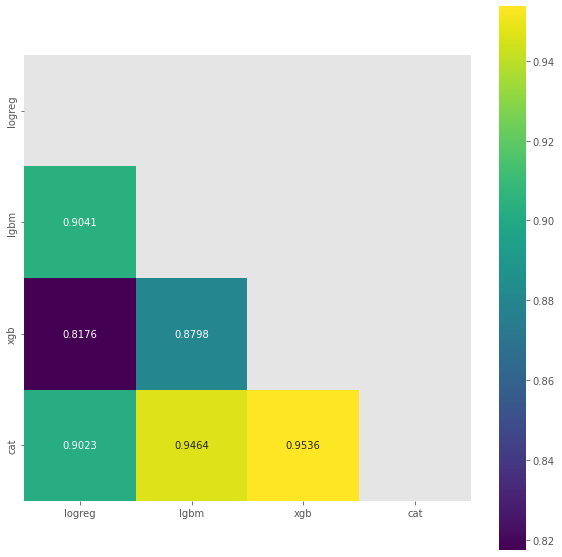

In [1558]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [1559]:
mean_scores(oof_predictions, y_learn)

AMean score: 0.74454
GMean score: 0.74497
Rank  score: 0.74437
GMean  rank: 0.74444


In [1582]:
from scipy.optimize import minimize

results_list = []   
weights_list = []  
preds = oof_predictions.values

def weights_objective(weights):
    y_ens = np.average(preds, axis=1, weights=weights)
    return roc_auc_score(y_learn, y_ens)

for k in range(100):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))


Optimized weights:
Best score: 0.7507


In [1562]:
valid_predictions = pd.DataFrame({'logreg': valid_log_predictions, 
                                  'lgbm': valid_lgbm_predictions, 
                                  'xgb': valid_xgb_predictions, 
                                  'cat': valid_cat_predictions})
valid_predictions.sample(5)

,logreg,lgbm,xgb,cat
14249,0.5940,0.5673,0.1000,0.2791
574,0.4850,0.5706,0.1068,0.2467
14696,0.3837,0.3359,0.0384,0.1703
2559,0.2270,0.2011,0.0309,0.1112
9771,0.4070,0.3172,0.0514,0.1754


In [1563]:
optimized_scores = np.average(valid_predictions, axis=1, weights=best_weights)
roc_auc_score(y_valid, optimized_scores)

0.7504572057866926

In [1564]:
# CI optimized
scores = create_bootstrap_metrics(y_valid, optimized_scores, roc_auc_score)

calculate_confidence_interval(scores)

(0.737174339382868, 0.7633692382258066)

In [1565]:
geo_optimized_scores = stats.gmean(valid_predictions, axis=1, weights=best_weights)
roc_auc_score(y_valid, geo_optimized_scores)

0.747725229960274

In [1566]:
scores = create_bootstrap_metrics(y_valid, geo_optimized_scores, roc_auc_score)

calculate_confidence_interval(scores)

(0.7351149630015194, 0.75997103367366)

In [1567]:
# LDA assumes correletions between variables
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

lda_estimators, _, _, _, oof_lda = make_modify_cross_validation(
                                                          oof_predictions, 
                                                          y_learn, 
                                                          lda, 
                                                          metric=roc_auc_score, 
                                                          cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                                                          error_to_be_outlier=False
                                                          )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7457, valid-score = 0.7644
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7478, valid-score = 0.7444
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7481, valid-score = 0.7419
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7473, valid-score = 0.7503
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7475, valid-score = 0.7483
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7482, valid-score = 0.7386
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7485, valid-score = 0.7378
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7475, valid-score = 0.7474
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7477, valid-score = 0.7489
Fold: 10, train-observations = 64468, valid-ob

In [1568]:
lda_train_predictions = pd.DataFrame(data=np.array([model.predict_proba(oof_predictions)[:,1] for model in lda_estimators]).T)

lda_valid_predictions = pd.DataFrame(data=np.array([model.predict_proba(valid_predictions)[:,1] for model in lda_estimators]).T)

In [1569]:
mean_scores(lda_valid_predictions, y_valid)

AMean score: 0.74702
GMean score: 0.74702
Rank  score: 0.74702
GMean  rank: 0.74702


In [1574]:
results_list_lda = []   
weights_list_lda = []  
preds_lda = lda_train_predictions.values

def weights_objective(weights):
    y_ens = np.average(preds_lda, axis=1, weights=weights)
    return roc_auc_score(y_learn, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_lda.shape[1])
    bounds = [(0,1)] * preds_lda.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list_lda.append(res.fun)
    weights_list_lda.append(res.x)

best_score_lda = np.max(results_list_lda)    
best_weights_lda = weights_list_lda[results_list_lda.index(best_score_lda)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score_lda))


Optimized weights:
Best score: 0.7477


In [1575]:
lda_optimized_amean_scores = np.average(lda_valid_predictions, axis=1, weights=best_weights_lda)

roc_auc_score(y_valid, lda_optimized_amean_scores)

0.7472106459048456

In [1576]:
# CI
scores = create_bootstrap_metrics(y_valid, lda_optimized_amean_scores, roc_auc_score)

calculate_confidence_interval(scores)

(0.7340142084978389, 0.7599700668380024)

In [1353]:
np.mean((0.7335965635883693, 0.7599568286973258))

0.7467766961428476

In [1354]:
pd.Series(data=np.abs(lda_optimized_amean_scores - y_valid)).sort_values(ascending=False)

APPLICATION_NUMBER
123652302   0.9859
123500545   0.9857
123543140   0.9853
123462701   0.9842
123650750   0.9839
             ...  
123713359   0.0136
123682785   0.0135
123521494   0.0132
123618322   0.0132
123712454   0.0128
Name: TARGET, Length: 17908, dtype: float64

In [1577]:
test_preds_cat = cat.predict_proba(data_test[features])[:,1]

In [1578]:
data_test_num = data_test.copy()

In [1579]:
data_test_num[['EDUCATION_LEVEL', 'FAMILY_STATUS', 'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']] = \
        encoder.transform(data_test_num[['EDUCATION_LEVEL', 'FAMILY_STATUS', 
                                   'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']])

In [1580]:
test_preds_lgbm = lgbm.predict_proba(data_test_num[features])[:,1]
test_preds_log = logreg.predict_proba(data_test_num[features])[:,1]
test_preds_xgb = xgb.predict_proba(data_test_num[features])[:,1]

In [1581]:
final_predictions = pd.DataFrame({'logreg': test_preds_log, 
                                  'lgbm': test_preds_lgbm, 
                                  'xgb': test_preds_xgb, 
                                  'cat': test_preds_cat})

In [1583]:
final_scores = np.average(final_predictions, axis=1, weights=best_weights)

In [1589]:
data_test[TARGET] = final_scores
final_part_one = data_test.reset_index()[[ID_COL, TARGET]]

In [1590]:
final_part_one

,APPLICATION_NUMBER,TARGET
0,123724268,0.3551
1,123456549,0.6315
2,123428178,0.5747
3,123671104,0.1046
4,123632747,0.1684
...,...,...
134170,123642343,0.0854
134171,123484380,0.0807
134172,123536402,0.2547
134173,123631557,0.1674


**Conclusion: predict scores by logreg, lgbm, xgb, catboost, init test_df with scores, apply optimized_scores = np.average(valid_predictions, axis=1, weights=best_weights)**

In [ ]:
"""
5) optuna night optimizing x3 cells
BEST: 0.73700, BASE: 0.73199

I.
1) predict 81% by cp features (features stats from overall train+test)
2) predict 18.7 % by merged cp, pay, hist, bki (model from part II)
3) 0.3% would be zero trash: mean by 1) and 2)
II.
1) concat train and test, preserve test_ids -> data
2) data + cp + bki + pay + hist
3) train cat -> lgbm -> xgb -> logreg
4) means, weighted means, lda stack
"""

## Part II

In [2175]:
def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'category']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [2176]:
def fill_nan_by_median_one(train_cleaned):
    for i in train_cleaned.columns:        
        train_cleaned[i] = train_cleaned[i].fillna(train_cleaned[i].median())
    return train_cleaned

def prepare_history():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    df_applications_history = pd.read_csv('applications_history.csv')
    
    df_applications_history.drop('PREV_APPLICATION_NUMBER', axis=1, inplace=True)
    
    categorical_feats = df_applications_history.select_dtypes(include="object").columns.tolist()
    df_applications_history = pd.get_dummies(df_applications_history, columns=categorical_feats)
    
    df_applications_history = df_applications_history.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))    
    
    df_applications_history = fill_nan_by_median_one(df_applications_history)

    apps=df_applications_history

    aggs ={column: ["max", "sum"] for column in df_applications_history.columns[1:]}

    df_applications_history = create_numerical_aggs(apps, groupby_id=ID_COL, aggs=aggs)

    df_applications_history = fill_nan_by_median_one(df_applications_history)  
    """
    print('Original shapes:', df_train.shape, df_test.shape)
    applications_numbers = set(df_applications_history[ID_COL].values)
    train_numbers = set(df_train[ID_COL].values)
    test_numbers  = set(df_test[ID_COL].values)    
    train_in_profiles = list(train_numbers & applications_numbers)
    test_in_profiles = list(test_numbers & applications_numbers)      
    df_train = df_train[(df_train[ID_COL].isin(train_in_profiles))]
    df_test = df_test[(df_test[ID_COL].isin(test_in_profiles))]    
    """
    target = df_train['TARGET']
    df_train = df_train.drop(['TARGET'], axis=1)
    
    contract_dict = {'Cash': 1, 'Credit Card': 2}
    df_train['NAME_CONTRACT_TYPE'] = df_train['NAME_CONTRACT_TYPE'].map(contract_dict)
    df_test['NAME_CONTRACT_TYPE'] = df_test['NAME_CONTRACT_TYPE'].map(contract_dict)

    df_train = pd.merge(df_train, df_applications_history, how='left', on=ID_COL)
    df_test = pd.merge(df_test, df_applications_history, how='left', on=ID_COL)    
    
    print('Final shapes:', df_train.shape, df_test.shape)    
          
    return df_train, target, df_test

In [2248]:
df_train, target, df_test = prepare_history()

Final shapes: (110093, 172) (165141, 172)


In [1727]:
hist_imp = calculate_feature_separating_ability(df_train, target)

In [1728]:
history_features = hist_imp[hist_imp > 0.005].index.tolist()

In [2249]:
df_train = df_train[history_features + [ID_COL]]
df_test = df_test[history_features + [ID_COL]]

In [2254]:
def bki_cr(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bki.csv', nrows = num_rows)
    bureau, bureau_cat = get_encoded(bureau, nan_as_category)

    bureau.drop(['BUREAU_ID'], axis=1, inplace= True)
    
    num_aggregations = {
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
    bureau_agg = bureau.groupby(ID_COL).agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby(ID_COL).agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on=ID_COL)

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby(ID_COL).agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on=ID_COL)

    return bureau_agg

def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns

In [2371]:
def prepare_cp_sec(data: pd.DataFrame, 
                   dropna: bool = True, 
                   create_features: bool = False,
                   is_category_encode: bool = False) -> pd.DataFrame:
    df = pd.read_csv('client_profile.csv')
    # fill missing values: 0 is reasonable
    # df.fillna(0, inplace=True)

    # deal with extreme outliers
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 50] = df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] <= 50, 'AMT_REQ_CREDIT_BUREAU_QRT'].max() + 1
    # df.loc[df['DAYS_ON_LAST_JOB'] > 50000, 'DAYS_ON_LAST_JOB'] = 366
    df['DAYS_ON_LAST_JOB'] = df['DAYS_ON_LAST_JOB'].replace(365243, np.nan)
    df.loc[df['TOTAL_SALARY'] > 1e+8, 'TOTAL_SALARY'] /= 1000.

    # IQR mark
    """
    df['IS_OUTLIER'] = 0
    for column in df.select_dtypes(include="number").columns:
        q1, q3 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        condition = ((df[column] > upper_bound) | (df[column] < lower_bound))
        df.loc[condition, 'IS_OUTLIER'] = 1
    """
    
    # transform categorical columns
    df.loc[df['GENDER'] == 'XNA', 'GENDER'] = df['GENDER'].mode()[0]
    df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
    df.loc[df['FAMILY_STATUS'] == 'Unknown', 'FAMILY_STATUS'] = 'Civil marriage'
    
    df['AGE'] = df['AGE'] / 365.25
    df['AGE_BIN'] = pd.cut(df['AGE'], bins=np.linspace(18, 70, 10), labels=False) + 1

    if create_features:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / (df['AMOUNT_ANNUITY'] + 1)
        df['NEW_STATUS'] = df['GENDER'].map({0: 'F', 1: 'M'}) + df['FAMILY_STATUS'].astype(str)
        df["RATIO_ANNUITY_TO_AGE"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["RATIO_CREDIT_TO_AGE"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["RATIO_SALARY_TO_AGE"] = df["TOTAL_SALARY"] / df["AGE"]
        df["RATIO_AGE_TO_EXPERIENCE"] = df["AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25)
        df["RATIO_CAR_TO_EXPERIENCE"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
        df["RATIO_CAR_TO_AGE"] = df["OWN_CAR_AGE"] / df["AGE"]
        aggs = {
                "TOTAL_SALARY": ["mean", "max", "min", "count"],
                "AMOUNT_CREDIT": ["mean", "max", "min", "count"],
                "AMOUNT_ANNUITY": ["mean", "max", "min", "count"]
                }

        stat = create_numerical_aggs(df, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION")
        df = df.merge(stat, on='EDUCATION_LEVEL', how='left')
        df["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] / (df["TOTAL_SALARY_MEAN_BY_EDUCATION"] + 1)
        df["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] - df["TOTAL_SALARY_MEAN_BY_EDUCATION"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT"] = df["AMOUNT_CREDIT"] / df["TOTAL_SALARY"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY"] = df["TOTAL_SALARY"] / (df["AMOUNT_CREDIT"] / (df["FAMILY_SIZE"] + 1))
        df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = df["AMOUNT_ANNUITY"] / (df["TOTAL_SALARY"] + 1) # redundant
        df["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = df["TOTAL_SALARY"] / (df["FAMILY_SIZE"] + 1)
        df["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.3, 1, 0)
        df["EDUCATION_FAMILY_STATUS"] = df["EDUCATION_LEVEL"].apply(str) + " | " + df["FAMILY_STATUS"].apply(str)
        stat = create_numerical_aggs(df, groupby_id="AGE_BIN", aggs=aggs, suffix="_AGE_INTERVAL")
        df = df.merge(stat, on='AGE_BIN', how='left')
        stat = create_numerical_aggs(df, groupby_id="FAMILY_STATUS", aggs=aggs, suffix="_BY_FAMILY_STATUS")
        df = df.merge(stat, on='FAMILY_STATUS', how='left')

        aggs = {"NEW_CREDIT_TO_ANNUITY_RATIO": ["mean"],
                "RATIO_SALARY_TO_AMOUNT_CREDIT": ["mean"]}
        stat = create_numerical_aggs(df, groupby_id=["GENDER", "AGE_BIN"], aggs=aggs, suffix="_GENDER_AGE_BIN")
        df = df.merge(stat, on=["GENDER", "AGE_BIN"], how='left')
        
        df['EXTERNAL_SCORE_WEIGHTED'] = df['EXTERNAL_SCORING_RATING_1'] * 2 + df['EXTERNAL_SCORING_RATING_2'] + df['EXTERNAL_SCORING_RATING_3'] * 3
        
        df['EXT_SCORE_1_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_2_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_3_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_CREDIT']
        
        df['EXT_SCORE_1_ANNUITY'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_2_ANNUITY'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_3_ANNUITY'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_ANNUITY']
        
        df['SALARY_REGION_POPULATION'] = df['TOTAL_SALARY'] * df['REGION_POPULATION']
        df['SALARY_JOB'] = df['TOTAL_SALARY'] / df["DAYS_ON_LAST_JOB"]
        df['CREDIT_JOB'] = df['AMOUNT_CREDIT'] / df["DAYS_ON_LAST_JOB"]
        df['ANNUITY_JOB'] = df['AMOUNT_ANNUITY'] / df["DAYS_ON_LAST_JOB"]
        funcs = ["min", "max", "mean", "nanmedian", "var"]
        for func in funcs:
            df[f"EXT_SCORES_{func}"] = eval("np.{}".format(func))(df[['EXTERNAL_SCORING_RATING_1',
                                                                      'EXTERNAL_SCORING_RATING_2',
                                                                      'EXTERNAL_SCORING_RATING_3']], axis=1)

    if is_category_encode:
        df, _ = get_encoded(df)
    
    df = reduce_memory_df(df)
    df = data.merge(df, on=ID_COL, how='left')
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

    if dropna:
        df.dropna(subset=df.columns.tolist()[4:], inplace=True) 
    # df.set_index(ID_COL, inplace=True)

    return df

In [2399]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X.shape

Memory usage of dataframe is 182.15 MB
Memory usage after optimization is: 90.60 MB
Decreased by 50.3%


(110093, 96)

In [2400]:
bureau = bki_cr()
bureau.shape

(273131, 34)

In [2401]:
X = X.merge(bureau, on=ID_COL, how='left')
#X = X.merge(df_train, on=ID_COL, how='left')  # as boruta filters them
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)
X.shape

(110093, 129)

In [2402]:
data_test.drop(TARGET, axis=1, inplace=True)
data_test = data_test.merge(bureau, on=ID_COL, how='left')
#data_test = data_test.merge(df_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [2242]:
################ split ###################
X2, y2 = cp_hist_bki.drop(TARGET, axis=1), cp_hist_bki[TARGET]
x_learn, x_holdout, y_learn2, y_holdout = train_test_split(X2, y2, test_size=0.15, shuffle=True, stratify=y2, random_state=seed)

In [2239]:
############# encode categories ###################
encoder_cat = ce.cat_boost.CatBoostEncoder(random_state=seed, a=10)
X2['EDUCATION_FAMILY_STATUS'] = encoder_cat.fit_transform(X2['EDUCATION_FAMILY_STATUS'], y2)

In [2240]:
########### get dummy variables ################
X2, _ = get_encoded(X2)
x_learn, x_holdout, y_learn2, y_holdout = train_test_split(X2, y2, test_size=0.15, shuffle=True, stratify=y2, random_state=seed)

In [2217]:
################ check split equality ####################
X_inspect = pd.concat([x_learn, x_holdout], axis=0)
y_inspect = np.hstack((np.ones(x_learn.shape[0]), np.zeros(x_holdout.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed).fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=inspector,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.4999


In [2409]:
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 212, 
                'learning_rate': 0.01, 
                'min_child_weight': 350, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

In [2404]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, stratify=y, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

46 attributes confirmed important: ['AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'ANNUITY_JOB', 'RATIO_CREDIT_TO_AGE', 'EXTERNAL_SCORE_WEIGHTED', 'EXT_SCORE_2_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SCORES_mean', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'SALARY_JOB', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_nanmedian', 'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'EXT_SCORE_2_ANNUITY', 'OWN_CAR_AGE', 'EXT_SCORES_max', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'EXT_SCORES_min', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'RATIO_SALARY_TO_AGE', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 'EXTERNAL_SCORING_

In [2062]:
# permutation importance with hold-out split
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params).fit(x_learn, y_learn2),
                                                  metric=roc_auc_score,
                                                  x_valid=x_holdout,
                                                  y_valid=y_holdout,
                                                  maximize=True,
                                                  probas=True)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:04<00:00, 24.62it/s]


In [2071]:
permutation_cols = X.columns[deltas > 0]

In [2407]:
borimp = ['AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
          'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'ANNUITY_JOB', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 
          'SALARY_REGION_POPULATION', 'RATIO_CREDIT_TO_AGE', 'EXTERNAL_SCORE_WEIGHTED', 'EXT_SCORE_2_AMT_CREDIT', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SCORES_mean', 
          'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 'EXT_SCORE_1_AMT_CREDIT', 'EXTERNAL_SCORING_RATING_2',
          'TOTAL_SALARY_COUNT_BY_EDUCATION', 'SALARY_JOB', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_nanmedian', 
          'RATIO_AGE_TO_EXPERIENCE', 'AMOUNT_ANNUITY_MIN_AGE_INTERVAL', 'GENDER', 'TOTAL_SALARY_MAX_BY_EDUCATION', 
          'EXT_SCORE_2_ANNUITY', 'OWN_CAR_AGE', 'EXT_SCORES_max', 'EXT_SCORES_var', 'EXT_SCORES_min', 
          'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 
          'EXTERNAL_SCORING_RATING_3', 'RATIO_SALARY_TO_AGE', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
          'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 
          'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 
          'AMOUNT_ANNUITY', 'NEW_STATUS', 'AMOUNT_CREDIT', 'RATIO_CAR_TO_EXPERIENCE', 'REGION_POPULATION', 
          'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
          'TOTAL_SALARY_MAX_AGE_INTERVAL', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 
          'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'AMOUNT_CREDIT_COUNT_BY_EDUCATION']

borimp_no_hist = ['AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 
                  'TOTAL_SALARY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'ANNUITY_JOB', 
                  'RATIO_CREDIT_TO_AGE', 'EXTERNAL_SCORE_WEIGHTED', 'EXT_SCORE_2_AMT_CREDIT', 
                  'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
                  'EXT_SCORES_mean', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 
                  'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'SALARY_JOB', 'EXT_SCORE_3_AMT_CREDIT', 
                  'EXT_SCORES_nanmedian', 'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'EXT_SCORE_2_ANNUITY', 'OWN_CAR_AGE', 
                  'EXT_SCORES_max', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'EXT_SCORES_min', 
                  'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 
                  'EXTERNAL_SCORING_RATING_3', 'RATIO_SALARY_TO_AGE', 'RATIO_ANNUITY_TO_AGE', 
                  'TOTAL_SALARY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 
                  'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 
                  'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'AMOUNT_ANNUITY', 'NEW_STATUS', 'AMOUNT_CREDIT', 
                  'RATIO_CAR_TO_EXPERIENCE', 'EXT_SCORES_var', 'AMT_REQ_CREDIT_BUREAU_QRT', 'TOTAL_SALARY_MAX_BY_EDUCATION', 
                  'EXT_SCORE_1_AMT_CREDIT', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 
                  'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 
                  'SALARY_REGION_POPULATION']

In [2410]:
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import combinations

class BestSet(BaseEstimator, TransformerMixin):
    def __init__(self, model, k_features=10, scoring="roc_auc"):
        self.scoring = scoring
        self.k_features = k_features
        self.model = model

    def fit(self, X, y):
        dim = X.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X, y, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim, leave=False):
                score = self._calc_score(X, y, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        return self
    def transform(self, X):
        best_indices = list(self.subsets_[np.argmax(self.scores_)])
        return X.iloc[:, best_indices]

    def _calc_score(self, X, y, indices):
        fold = KFold(n_splits=5, shuffle=True, random_state=seed)
        scores = cross_val_score(
                                 estimator=self.model,
                                 X=X.iloc[:, list(indices)], 
                                 y=y, 
                                 cv=fold, 
                                 scoring=self.scoring,
                                 n_jobs=-1
                                 )
        score = np.mean(scores)
        return score

In [2413]:
best_selector = BestSet(model=LGBMClassifier(**lgbm_params), k_features=20).fit(X[borimp_no_hist], y)

In [2414]:
max(best_selector.scores_), X[borimp_no_hist].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])]

(0.7193565366059312,
 Index(['CREDIT_JOB', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_AGE',
        'RATIO_CREDIT_TO_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
        'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_2',
        'GENDER', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN',
        'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3',
        'RATIO_ANNUITY_TO_AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO',
        'EXTERNAL_SCORING_RATING_1', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION',
        'NEW_STATUS', 'AMOUNT_CREDIT', 'RATIO_CAR_TO_EXPERIENCE',
        'TOTAL_SALARY_MAX_BY_EDUCATION', 'TOTAL_SALARY_MAX_AGE_INTERVAL',
        'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 'SALARY_REGION_POPULATION'],
       dtype='object'))

In [2266]:
boruta_selected = ['CREDIT_JOB', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_AGE',
                'RATIO_CREDIT_TO_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_2',
                'GENDER', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN',
                'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3',
                'RATIO_ANNUITY_TO_AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO',
                'EXTERNAL_SCORING_RATING_1', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION',
                'NEW_STATUS', 'AMOUNT_CREDIT', 'RATIO_CAR_TO_EXPERIENCE',
                'TOTAL_SALARY_MAX_BY_EDUCATION', 'TOTAL_SALARY_MAX_AGE_INTERVAL',
                'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 'SALARY_REGION_POPULATION']

In [2267]:
cat_boruta_cols = [column for column in X[borimp].columns if X[column].dtype == "category"]
cat_boruta_scols = [column for column in X[boruta_selected].columns if X[column].dtype == "category"]

In [2408]:
# model 1: cp + bki + hist boruta selected
lgbm_params1 = {
                'metric':"auc", 
                'is_unbalance': True,
                'verbose': -1,
                'random_state': seed,
                'boosting_type': 'goss',
                'colsample_bytree': 0.33,
                'learning_rate': 0.01,
                'max_bin': 80,
                'max_depth': 6,  
                'min_child_weight': 567,
                'min_split_gain': 0.002,
                'n_estimators': 1000,
                'num_leaves': 12, 
                'min_child_samples': 100,
                'reg_alpha': 10.95,
                'reg_lambda': 40.15,
                'subsample': 0.79,
}

params = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
}

model1_estimators, _, _, _, oof_scores1 = make_modify_cross_validation(
                                            X[borimp_no_hist], 
                                            y, 
                                            LGBMClassifier(**params), 
                                            metric=roc_auc_score, 
                                            cv_strategy=KFold(n_splits=5, shuffle=True, random_state=seed), 
                                            error_to_be_outlier=False,
                                            early=100 # 30
                                            )

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.8423, valid-score = 0.7432
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.8438, valid-score = 0.726
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.8231, valid-score = 0.7307
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.8533, valid-score = 0.7317
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.8348, valid-score = 0.7148
CV-results train: 0.8395 +/- 0.01
CV-results valid: 0.7293 +/- 0.009
OOF-score = 0.7285


In [2398]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores1, roc_auc_score))

(0.7229071272080041, 0.7339299899085198)

In [2277]:
model1_test_preds = np.array([estimator.predict_proba(data_test[borimp])[:,1] for estimator in model1_estimators]).T
model1_test_preds = np.mean(model1_test_preds, axis=1)

In [2280]:
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 200, 
                'early_stopping_rounds': 20,  
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 8.68,  
                'colsample_bylevel': 0.839,  
                'depth': 5, 
                'l2_leaf_reg': 31.397,  
                'learning_rate': 0.013, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 128,  
}
X2 = X.copy(deep=True)
X2[cat_boruta_scols] = X2[cat_boruta_scols].astype("object")
X2[cat_boruta_scols] = X2[cat_boruta_scols].fillna("None")
X2[cat_boruta_scols] = X2[cat_boruta_scols].astype("category")

model2_estimators, _, _, _, oof_scores2 = make_modify_cross_validation(
                                                            X2[boruta_selected], 
                                                            y, 
                                                            CatBoostClassifier(cat_features=cat_boruta_scols, **cat_params), 
                                                            metric=roc_auc_score, 
                                                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed-1), 
                                                            error_to_be_outlier=False,
                                                            early=False
                                                            )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7167, valid-score = 0.7051
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7161, valid-score = 0.7185
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7154, valid-score = 0.7195
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.715, valid-score = 0.7104
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7157, valid-score = 0.7223
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7148, valid-score = 0.714
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7148, valid-score = 0.7139
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7171, valid-score = 0.7051
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7177, valid-score = 0.7015
Fold: 10, train-observations = 99084, v

In [2281]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores2, roc_auc_score))

(0.7062079082497474, 0.7171828725660462)

In [2282]:
data_test2 = data_test.copy(deep=True)
data_test2[cat_boruta_scols] = data_test2[cat_boruta_scols].astype("object")
data_test2[cat_boruta_scols] = data_test2[cat_boruta_scols].fillna("None")
data_test2[cat_boruta_scols] = data_test2[cat_boruta_scols].astype("category")

model2_test_preds = np.array([estimator.predict_proba(data_test2[boruta_selected])[:,1] for estimator in model2_estimators]).T
model2_test_preds = np.mean(model2_test_preds, axis=1)

In [2285]:
lgbm_params3 = {
                'metric':"auc", 
                'is_unbalance': True,
                'verbose': -1,
                'random_state': seed,
                'boosting_type': 'goss',
                'colsample_bytree': 0.33,
                'learning_rate': 0.01,
                'max_bin': 80,
                'max_depth': 3,
                'min_child_weight': 567,
                'min_split_gain': 0.002,
                'n_estimators': 858,
                'num_leaves': 4,
                'min_child_samples': 100,
                'reg_alpha': 1.95,
                'reg_lambda': 40.15,
                'subsample': 0.79,
}

model3_estimators, _, _, _, oof_scores3 = make_modify_cross_validation(
                                                        X, 
                                                        y, 
                                                        LGBMClassifier(**lgbm_params3), 
                                                        metric=roc_auc_score, 
                                                        cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed+seed), 
                                                        error_to_be_outlier=False,
                                                        early=30
                                                        )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7248, valid-score = 0.7244
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7289, valid-score = 0.7085
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.727, valid-score = 0.7252
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7221, valid-score = 0.7156
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7273, valid-score = 0.7207
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7286, valid-score = 0.7156
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7204, valid-score = 0.7261
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7225, valid-score = 0.7089
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7273, valid-score = 0.7213
Fold: 10, train-observations = 99084, 

In [2286]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores3, roc_auc_score))

(0.7126162635419374, 0.7234303071684319)

In [2290]:
model3_test_preds = np.array([estimator.predict_proba(data_test)[:,1] for estimator in model3_estimators]).T
model3_test_preds = np.mean(model3_test_preds, axis=1)

In [2288]:
lgbm_params4 = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': seed,
    'silent': -1,
}

model4_estimators, _, _, _, oof_scores4 = make_modify_cross_validation(
                                                        X[borimp], 
                                                        y, 
                                                        LGBMClassifier(**lgbm_params4), 
                                                        metric=roc_auc_score, 
                                                        cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed%2), 
                                                        error_to_be_outlier=False,
                                                        early=50
                                                        )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7949, valid-score = 0.7213
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7948, valid-score = 0.7314
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7945, valid-score = 0.7302
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7942, valid-score = 0.7309
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7942, valid-score = 0.726
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7951, valid-score = 0.7202
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7941, valid-score = 0.7384
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7949, valid-score = 0.7248
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7949, valid-score = 0.728
Fold: 10, train-observations = 99084, v

In [2289]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores4, roc_auc_score))

(0.7200714109711599, 0.7310863905784573)

In [2291]:
model4_test_preds = np.array([estimator.predict_proba(data_test[borimp])[:,1] for estimator in model4_estimators]).T
model4_test_preds = np.mean(model4_test_preds, axis=1)

In [2292]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2294]:
X_, _ = get_encoded(X)
X_.fillna(0, inplace=True)
X_.isna().sum().sum()

0

In [2295]:
x_train, x_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=seed)

In [2296]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
class_weights

{0: 0.5444059834342935, 1: 6.129871937639198}

In [2297]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [2298]:
batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train)).cache().batch(batch_size).prefetch(0)
val_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test)).cache().batch(batch_size).prefetch(2)

In [2303]:
tf_model1 = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation='relu', input_shape=(x_train_scaled.shape[-1], ), 
                                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

In [2300]:
num_features = x_train.shape[1]
num_preds = 1

def get_model():
    inp = tf.keras.layers.Input((num_features*num_preds,))
    x = tf.keras.layers.Reshape((num_features*num_preds,1))(inp)
    x = tf.keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(24,1, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16,1, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(4,1, activation='elu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Reshape((num_features*4,1))(x)
    x = tf.keras.layers.AveragePooling1D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inp, outputs=out)

tf_model2 = get_model()

In [2304]:
metrics = [
           tf.keras.metrics.AUC(name='roc_auc'),
]

tf_model1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=metrics)
tf_model2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=metrics)

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_roc_auc', min_lr=1e-6),
             tf.keras.callbacks.EarlyStopping(monitor='val_roc_auc', patience=10, restore_best_weights=True),
            ]

In [2305]:
history = tf_model1.fit(train_ds, epochs=25, verbose=2, callbacks=callbacks,
                     validation_data=val_ds, class_weight=class_weights, 
                     )

Epoch 1/25
689/689 - 3s - loss: 1.1565 - roc_auc: 0.5925 - val_loss: 0.9684 - val_roc_auc: 0.7034 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 2/25
689/689 - 3s - loss: 0.9459 - roc_auc: 0.6677 - val_loss: 0.8616 - val_roc_auc: 0.7077 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 3/25
689/689 - 3s - loss: 0.8255 - roc_auc: 0.6835 - val_loss: 0.7760 - val_roc_auc: 0.7082 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 4/25
689/689 - 3s - loss: 0.7462 - roc_auc: 0.6856 - val_loss: 0.7088 - val_roc_auc: 0.7061 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 5/25
689/689 - 3s - loss: 0.7012 - roc_auc: 0.6849 - val_loss: 0.6688 - val_roc_auc: 0.7042 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 6/25
689/689 - 3s - loss: 0.6803 - roc_auc: 0.6868 - val_loss: 0.6588 - val_roc_auc: 0.7063 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 7/25
689/689 - 3s - loss: 0.6671 - roc_auc: 0.6963 - val_loss: 0.6697 - val_roc_auc: 0.7078 - lr: 1.0000e-04 - 3s/epoch - 4ms/step
Epoch 8/25
689/689 - 3s - loss: 0.6599 - roc_auc: 0.7002 - val_lo

In [2306]:
history = tf_model2.fit(train_ds, epochs=25, verbose=2, callbacks=callbacks,
                        validation_data=val_ds, class_weight=class_weights, 
                        )

Epoch 1/25
689/689 - 20s - loss: 0.6530 - roc_auc: 0.6762 - val_loss: 1.1411 - val_roc_auc: 0.6974 - lr: 0.0010 - 20s/epoch - 28ms/step
Epoch 2/25
689/689 - 19s - loss: 0.6366 - roc_auc: 0.6880 - val_loss: 0.7113 - val_roc_auc: 0.7033 - lr: 0.0010 - 19s/epoch - 28ms/step
Epoch 3/25
689/689 - 19s - loss: 0.6335 - roc_auc: 0.6921 - val_loss: 0.5544 - val_roc_auc: 0.7068 - lr: 0.0010 - 19s/epoch - 27ms/step
Epoch 4/25
689/689 - 19s - loss: 0.6312 - roc_auc: 0.6952 - val_loss: 0.6046 - val_roc_auc: 0.7099 - lr: 0.0010 - 19s/epoch - 27ms/step
Epoch 5/25
689/689 - 19s - loss: 0.6293 - roc_auc: 0.6976 - val_loss: 0.5145 - val_roc_auc: 0.7123 - lr: 0.0010 - 19s/epoch - 27ms/step
Epoch 6/25
689/689 - 19s - loss: 0.6282 - roc_auc: 0.6990 - val_loss: 0.4853 - val_roc_auc: 0.7144 - lr: 0.0010 - 19s/epoch - 28ms/step
Epoch 7/25
689/689 - 19s - loss: 0.6212 - roc_auc: 0.7085 - val_loss: 0.6329 - val_roc_auc: 0.7188 - lr: 1.0000e-04 - 19s/epoch - 28ms/step
Epoch 8/25
689/689 - 21s - loss: 0.6201 - ro

In [2332]:
tf1_total = tf_model1.predict(scaler.transform(X_)).ravel()
tf2_total = tf_model2.predict(scaler.transform(X_)).ravel()

tf_data_test = data_test.copy(deep=True)
tf_data_test, _ = get_encoded(tf_data_test)
tf_data_test.fillna(0, inplace=True)

tf1_total_test = tf_model1.predict(scaler.transform(tf_data_test)).ravel()
tf2_total_test = tf_model2.predict(scaler.transform(tf_data_test)).ravel()

**make oof dataset**

In [2333]:
oof_predictions_two = pd.DataFrame({f"model_{i}": mdl for i, mdl in enumerate((oof_scores1, 
                                                                               oof_scores2,
                                                                               oof_scores3, 
                                                                               oof_scores4,
                                                                               tf1_total,
                                                                               tf2_total), 1)})
oof_predictions_two.sample(5)

,model_1,model_2,model_3,model_4,model_5,model_6
18454,0.7098,0.3884,0.7321,0.1635,0.6793,0.7130
18385,0.5037,0.2568,0.5121,0.0862,0.5096,0.5021
150,0.3276,0.1840,0.3766,0.0422,0.4471,0.4255
32091,0.2040,0.0906,0.1839,0.0263,0.1828,0.1935
54954,0.8814,0.4766,0.8637,0.3986,0.7525,0.8133


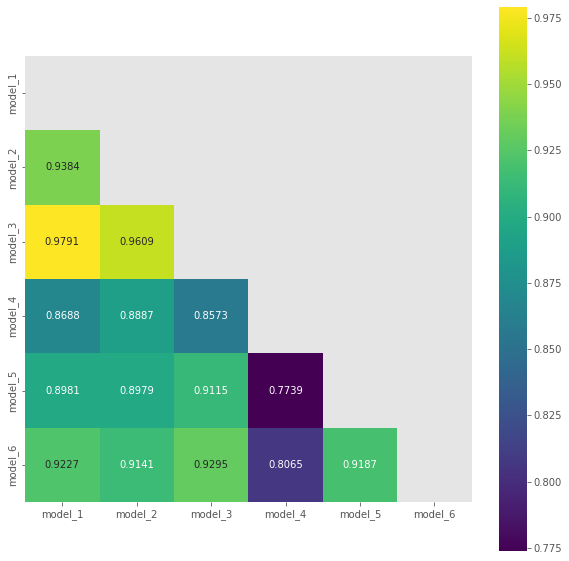

In [2334]:
corr = oof_predictions_two.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [2335]:
test_predictions_two = pd.DataFrame({f"model_{i}": mdl for i, mdl in enumerate((model1_test_preds,
                                                                                model2_test_preds,
                                                                                model3_test_preds,
                                                                                model4_test_preds,
                                                                                tf1_total_test,
                                                                                tf2_total_test), 1)})

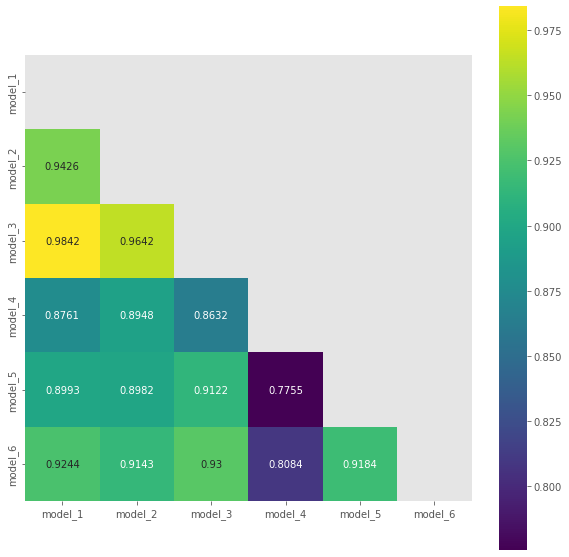

In [2336]:
corr = test_predictions_two.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [2337]:
mean_scores(oof_predictions_two, y)

AMean score: 0.72532
GMean score: 0.72633
Rank  score: 0.72386
GMean  rank: 0.72405


In [2338]:
results_list_two = []   
weights_list_two = []  
preds_two = oof_predictions_two.values

def weights_objective(weights):
    y_ens = np.average(preds_two, axis=1, weights=weights)
    return roc_auc_score(y2, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_two.shape[1])
    bounds = [(0,1)] * preds_two.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list_two.append(res.fun)
    weights_list_two.append(res.x)

best_score_two = np.max(results_list_two)    
best_weights_two = weights_list_two[results_list_two.index(best_score_two)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score_two))


Optimized weights:
Best score: 0.7292


In [2339]:
optimized_scores_two = np.average(oof_predictions_two, axis=1, weights=best_weights_two)
roc_auc_score(y, optimized_scores_two)

0.7291933807172566

In [2340]:
lda2 = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

lda_estimators2, _, _, _, oof_lda2 = make_modify_cross_validation(
                                                          oof_predictions_two, 
                                                          y, 
                                                          lda2, 
                                                          metric=roc_auc_score, 
                                                          cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                                                          error_to_be_outlier=False
                                                          )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7316, valid-score = 0.7344
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7319, valid-score = 0.731
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7316, valid-score = 0.7334
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7322, valid-score = 0.7287
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7319, valid-score = 0.7308
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7317, valid-score = 0.7322
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7309, valid-score = 0.7409
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7319, valid-score = 0.7313
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7321, valid-score = 0.729
Fold: 10, train-observations = 99084, v

In [2341]:
train_lda_preds = np.array([estimator.predict_proba(oof_predictions_two)[:,1] for estimator in lda_estimators2]).T
train_lda_preds = pd.DataFrame(data=train_lda_preds)
mean_scores(train_lda_preds, y)

AMean score: 0.73186
GMean score: 0.73186
Rank  score: 0.73185
GMean  rank: 0.73185


In [2342]:
results_list_two_lda = []   
weights_list_two_lda = []  
preds_two_lda = train_lda_preds.values

def weights_objective(weights):
    y_ens = np.average(preds_two_lda, axis=1, weights=weights)
    return roc_auc_score(y, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_two_lda.shape[1])
    bounds = [(0,1)] * preds_two_lda.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list_two_lda.append(res.fun)
    weights_list_two_lda.append(res.x)

best_score_two_lda = np.max(results_list_two_lda)    
best_weights_two_lda = weights_list_two_lda[results_list_two_lda.index(best_score_two_lda)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score_two_lda))


Optimized weights:
Best score: 0.7319


In [2343]:
optimized_scores_two_lda = np.average(train_lda_preds, axis=1, weights=best_weights_two_lda)
roc_auc_score(y, optimized_scores_two_lda)

0.7318844305593912

In [2344]:
calculate_confidence_interval(create_bootstrap_metrics(y, optimized_scores_two_lda, roc_auc_score))

(0.7267196527865419, 0.7370103694488828)

In [2345]:
test_lda_preds = np.array([estimator.predict_proba(test_predictions_two)[:,1] for estimator in lda_estimators2]).T

In [2347]:
test_lda_preds_scores = np.average(test_lda_preds, axis=1, weights=best_weights_two_lda)

In [2353]:
final_part_two = pd.DataFrame({ID_COL: test[ID_COL], TARGET: test_lda_preds_scores})

In [2362]:
submission = test.merge(final_part_one, on=ID_COL, how='left')
submission.drop('NAME_CONTRACT_TYPE', axis=1, inplace=True)

In [2363]:
submission.loc[submission[TARGET].isna(), TARGET] = final_part_two.loc[submission[TARGET].isna(), TARGET]

In [2367]:
submission.to_csv('submission.csv', index=False)

In [2368]:
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "test1"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.91M [00:00<?, ?B/s]
  4%|4         | 216k/4.91M [00:00<00:05, 918kB/s]
 23%|##2       | 1.12M/4.91M [00:00<00:00, 4.10MB/s]
 34%|###4      | 1.69M/4.91M [00:00<00:01, 2.55MB/s]
 64%|######3   | 3.14M/4.91M [00:00<00:00, 5.21MB/s]
100%|##########| 4.91M/4.91M [00:00<00:00, 8.12MB/s]
100%|##########| 4.91M/4.91M [00:02<00:00, 2.38MB/s]


In [ ]:
# boruta
# models CV (boosting), optimization (auc -> 0.735), optuna CV (np.mean or np.min or np.std(minimize) score)
# CI
# oof preds mean_scores, weighted mean_scores, lda/log stack
# concat predictions (check first submit and compare with CI, define next steps)

In [2161]:
def profiling(df):
    
    df['DAYS_ON_LAST_JOB'].replace(365243, np.nan, inplace= True)
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / df['AMOUNT_ANNUITY']
    df['NEW_STATUS'] = df['GENDER'] + df['FAMILY_STATUS'].astype(str)
    
    df, cat_cols = get_encoded(df, nan_as_category=False)
    
    return df

def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


raw_train = pd.read_csv('train.csv')
raw_cp = pd.read_csv('client_profile.csv')

train_ = raw_train.merge(raw_cp, on=ID_COL, how='left')

target_ = train_[TARGET]

train_ = train_.drop([ID_COL, TARGET], axis=1)

train_ = profiling(train_)

train_['NEW_STATUS_FUnknown'] = 0
train_['NEW_STATUS_XNACivil marriage'] = 0

In [2159]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):

    estimators, folds_scores = [], []
    
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", 
            verbose=500, 
            early_stopping_rounds=50
        )
        train_score = model.predict_proba(x_train)[:,1]
        train_score = roc_auc_score(y_train, train_score)
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
        estimators.append(model)

    print_scores(folds_scores)
    return estimators, oof_preds

def print_scores(folds_scores):
    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{np.mean(folds_scores):.5f}")
    print("*" * 50)

In [2395]:
lgbm_params_ = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}
cv_strategy = KFold(n_splits=5, random_state=seed, shuffle=True)

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(lgbm_params_, train_, target_, cv=cv_strategy)

Thu Aug 25 01:48:07 2022, Cross-Validation, 110093 rows, 157 cols
[500]	valid_0's auc: 0.737028	valid_0's binary_logloss: 0.24635
[1000]	valid_0's auc: 0.741959	valid_0's binary_logloss: 0.244228
Fold 1, Train score = 0.84366, Valid score = 0.74252
Fold 2, Train score = 0.73832, Valid score = 0.70785
[500]	valid_0's auc: 0.725577	valid_0's binary_logloss: 0.254253
[1000]	valid_0's auc: 0.729708	valid_0's binary_logloss: 0.25261
Fold 3, Train score = 0.83795, Valid score = 0.72990
[500]	valid_0's auc: 0.72168	valid_0's binary_logloss: 0.256796
[1000]	valid_0's auc: 0.727379	valid_0's binary_logloss: 0.254875
Fold 4, Train score = 0.85171, Valid score = 0.72826
[500]	valid_0's auc: 0.709831	valid_0's binary_logloss: 0.25993
[1000]	valid_0's auc: 0.714712	valid_0's binary_logloss: 0.258507
Fold 5, Train score = 0.86172, Valid score = 0.71629
Score by each fold: [0.74252, 0.70785, 0.7299, 0.72826, 0.71629]
Mean score by each fold:0.72496
**************************************************


In [99]:
def bki_cr(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bki.csv', nrows = num_rows)
    bureau, bureau_cat = get_encoded(bureau, nan_as_category)

    bureau.drop(['BUREAU_ID'], axis=1, inplace= True)
    
    num_aggregations = {
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
    bureau_agg = bureau.groupby(ID_COL).agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby(ID_COL).agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on=ID_COL)

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby(ID_COL).agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on=ID_COL)

    return bureau_agg
def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
def prepare_bki_sec() -> pd.DataFrame:
    df = pd.read_csv('bki.csv')
    df.drop('BUREAU_ID', axis=1, inplace=True)
    # fill nans with zeros
    df.fillna(0, inplace=True)

    # large values 
    df['susp'] = 0
    
    sharp_columns = {column: df[column].kurtosis() for column in df.select_dtypes(include="number").columns}
    for column, value in sharp_columns.items():
        if np.abs(value) > 10:
            condition = ((df[column] < np.percentile(df[column], 1)) | (df[column] > np.percentile(df[column], 99)))
            df.loc[condition, 'susp'] = 1
            # p1 = np.percentile(df[column], 1)
            # p2 = np.percentile(df[column], 99)
            # df[column] = np.clip(df[column], p1, p2)
    
    # create new features: mean and sum of AMTs grouped by credit-type
    amount_cols = [col for col in df.columns if col.startswith('AMT')]
    for i, column in enumerate(amount_cols, 1):
        df[f"{column}_CREDIT_TYPE"] = df.groupby('CREDIT_TYPE')[column].transform("mean")
    
    df['AMT_SUM'] = df[amount_cols].sum(axis=1)
    df['AMT_KUR'] = df[amount_cols].kurtosis(axis=1)

    # reduce dataset size
    df = df[df[ID_COL].isin(list(train_ids | test_ids))]

    # mean and sum 
    agg_funcs = dict(zip(amount_cols, [["mean", "sum"]]*len(amount_cols)))
    mask = df['CREDIT_ACTIVE'] == 'Active'
    active_agg = create_numerical_aggs(data=df[mask], groupby_id=ID_COL, aggs=agg_funcs, suffix="_BY_CREDIT_ACTIVE").fillna(0)

    mask = df['CREDIT_ACTIVE'] == 'Closed'
    inactive_agg = create_numerical_aggs(data=df[mask], groupby_id=ID_COL, aggs=agg_funcs, suffix="_BY_CREDIT_INACTIVE").fillna(0)

    # aggregate by ID_COL with different statistics to preserve individual loans info
    agg_funcs = {column: ["mean", "count", "min", "max", "std", "sum"] for column in df.select_dtypes(exclude="object").columns[1:]}
    num_df = create_numerical_aggs(data=df.select_dtypes(exclude="object"), groupby_id=ID_COL, aggs=agg_funcs).fillna(0)

    cat_df = create_categorical_aggs(data=df, groupby_id=ID_COL, features=['CREDIT_CURRENCY', 'CREDIT_TYPE']).fillna(0)

    df = pd.merge(num_df, cat_df, on=ID_COL, how='left')
    # df = pd.merge(df, num_cat, on=ID_COL, how='left')
    df = df.merge(active_agg, how='left', on=ID_COL)
    df= df.merge(inactive_agg, on=ID_COL, how='left')
    del cat_df, num_df, active_agg, inactive_agg

    df.fillna(0, inplace=True)
    # reduce memory usage
    df = reduce_memory_df(df)

    return df
select = [sel for sel in selected if not sel.startswith('NAME')]
bki_fin = prepare_bki_sec()[select + [ID_COL]]
bki_fin_train = bki_fin[bki_fin[ID_COL].isin(train_ids)]
bki_fin_test = bki_fin[bki_fin[ID_COL].isin(test_ids)]